# Install modules

In [53]:
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import TimeSeriesSplit
import tensorflow.keras.backend as K
import os
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM
from keras.optimizers import Adam
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use GPU device 0

# Get data in right format

In [46]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("preprocesseddata.csv",index_col="datetime")

#splitting into target and input variables
X = df.drop(['classification_region1', 'classification_region2', 'classification_region3'], axis=1)
y1 = df[['classification_region1']]
y2 = df[['classification_region2']]
y3 = df[['classification_region3']]

# Define the number of splits for the TimeSeriesSplit
n_splits = 5

# Define the TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=n_splits)

# Build model

In [47]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [48]:
def transformer_model(input_shape, num_classes, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units,
                      dropout=0, mlp_dropout=0):
    
    output_regions = []
    input_layer = keras.Input(shape=input_shape) 
        
    #REGION1
    #create multiple transformer blocks
    for _ in range(num_transformer_blocks):
        x1 = transformer_encoder(input_layer, head_size, num_heads, ff_dim, dropout)

    x1 = layers.GlobalAveragePooling1D(data_format="channels_first")(x1)

    #creaete dense layer
    for dim in mlp_units:
        x1 = layers.Dense(dim, activation="relu")(x1)
        x1 = layers.Dropout(mlp_dropout)(x1)
        
          
    outputs1 = layers.Dense(num_classes, activation="sigmoid", name="output1")(x1)
    output_regions.append(outputs1)
    
    #REGION1
    #create multiple transformer blocks
    for _ in range(num_transformer_blocks):
        x2 = transformer_encoder(input_layer, head_size, num_heads, ff_dim, dropout)

    x2 = layers.GlobalAveragePooling1D(data_format="channels_first")(x2)

    #creaete dense layer
    for dim in mlp_units:
        x2 = layers.Dense(dim, activation="relu")(x2)
        x2 = layers.Dropout(mlp_dropout)(x2)
        
          
    outputs2 = layers.Dense(num_classes, activation="sigmoid", name="output2")(x2)
    output_regions.append(outputs2)
    
    
    #REGION1
    #create multiple transformer blocks
    for _ in range(num_transformer_blocks):
        x3 = transformer_encoder(input_layer, head_size, num_heads, ff_dim, dropout)

    x3 = layers.GlobalAveragePooling1D(data_format="channels_first")(x3)

    #creaete dense layer
    for dim in mlp_units:
        x3 = layers.Dense(dim, activation="relu")(x3)
        x3 = layers.Dropout(mlp_dropout)(x3)
        
          
    outputs3 = layers.Dense(num_classes, activation="sigmoid", name="output3")(x3)
    output_regions.append(outputs3)
        
    model = keras.Model(inputs=input_layer, outputs= output_regions)

    return model

# Train model using timeseries split cross validation

In [49]:
epochs = 200
batch_size = 32



# Define the lists to store the training and validation scores
trainf1_scores_output1 = []
trainf1_scores_output2 = []
trainf1_scores_output3 = []
valf1_scores_output1 = []
valf1_scores_output2 = []
valf1_scores_output3 = []

# Loop over the splits of the TimeSeriesSplit
for train_index, val_index in tscv.split(X):

    # Split the data into training and validation sets
    x_train, x_val = X.iloc[train_index], X.iloc[val_index]
    y1_train, y1_val = y1.iloc[train_index], y1.iloc[val_index]
    y2_train, y2_val = y2.iloc[train_index], y2.iloc[val_index]
    y3_train, y3_val = y3.iloc[train_index], y3.iloc[val_index]
    
    # One-hot encode the binary targets
    y1_train = to_categorical(y1_train, num_classes=2)
    y1_val = to_categorical(y1_val, num_classes=2)
    y2_train = to_categorical(y2_train, num_classes=2)
    y2_val = to_categorical(y2_val, num_classes=2)
    y3_train = to_categorical(y3_train, num_classes=2)
    y3_val = to_categorical(y3_val, num_classes=2)
    
    # Convert to numpy and reshape to 3D
    x_train = x_train.values.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_val = x_val.values.reshape((x_val.shape[0], x_val.shape[1], 1))
    
    #create some callbacks to improve the model
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            "timeseries_transformer", save_best_only=True, monitor="val_loss"
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
        ),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1),
    ]
    
    model = transformer_model(input_shape=x_train.shape[1:], 
    num_classes=2,
    head_size=64,
    num_heads=8,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.2
    )
    
    
    
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[keras.metrics.Precision(name='precision'),
                 keras.metrics.Recall(name='recall'),
                 keras.metrics.AUC(name='auc')]
    )

    # Fit the model
    history = model.fit(
        x_train,
        [y1_train, y2_train, y3_train],
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=(x_val, [y1_val, y2_val, y3_val]),
        verbose=1,
    )
    
    print(history.history.keys())
    
    
    #Calculate training performance using f1-score
    precision1, recall1 = history.history["output1_precision"][-1], history.history["output1_recall"][-1]
    trainf1_scores_output1.append((2 * precision1 * recall1 / (precision1 + recall1)))
    precision2, recall2 = history.history["output2_precision"][-1], history.history["output2_recall"][-1]
    trainf1_scores_output2.append((2 * precision2 * recall2 / (precision2 + recall2)))
    precision3, recall3 = history.history["output3_precision"][-1], history.history["output3_recall"][-1]
    trainf1_scores_output3.append((2 * precision3 * recall3 / (precision3 + recall3)))
    
    #Calculate training performance using f1-score
    val_precision1, val_recall1 = history.history["val_output1_precision"][-1], history.history["val_output1_recall"][-1]
    valf1_scores_output1.append((2 * val_precision1 * val_recall1 / (val_precision1 + val_recall1)))
    val_precision2, val_recall2 = history.history["val_output2_precision"][-1], history.history["val_output2_recall"][-1]
    valf1_scores_output2.append((2 * val_precision2 * val_recall2 / (val_precision2 + val_recall2)))
    val_precision3, val_recall3 = history.history["val_output3_precision"][-1], history.history["val_output3_recall"][-1]
    valf1_scores_output3.append((2 * val_precision3 * val_recall3 / (val_precision3 + val_recall3)))

#Define the filename for the saved model
model_filename = "timeseries_transformer"
#Save the model
model.save(model_filename)


print("Output 1 Training F1: {:.2f}%".format(trainf1_scores_output1[-1] * 100))
print("Output 1 Validation F1: {:.2f}%".format(valf1_scores_output1[-1] * 100))
print("Output 2 Training F1: {:.2f}%".format(trainf1_scores_output2[-1] * 100))
print("Output 2 Validation F1: {:.2f}%".format(valf1_scores_output2[-1] * 100))
print("Output 3 Training F1: {:.2f}%".format(trainf1_scores_output3[-1] * 100))
print("Output 3 Validation F1: {:.2f}%".format(valf1_scores_output3[-1] * 100))

Epoch 1/200
 9/10 [==========================>...] - ETA: 0s - loss: 1.3541 - output1_loss: 0.4603 - output2_loss: 0.3328 - output3_loss: 0.5610 - output1_precision: 0.8419 - output1_recall: 0.7951 - output1_auc: 0.8757 - output2_precision: 0.8864 - output2_recall: 0.9479 - output2_auc: 0.9604 - output3_precision: 0.7306 - output3_recall: 0.7535 - output3_auc: 0.7899

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


10/10 [==============================] - 14s 945ms/step - loss: 1.3515 - output1_loss: 0.4593 - output2_loss: 0.3323 - output3_loss: 0.5599 - output1_precision: 0.8425 - output1_recall: 0.7958 - output1_auc: 0.8764 - output2_precision: 0.8867 - output2_recall: 0.9481 - output2_auc: 0.9606 - output3_precision: 0.7315 - output3_recall: 0.7543 - output3_auc: 0.7910 - val_loss: 0.9761 - val_output1_loss: 0.3691 - val_output2_loss: 0.2159 - val_output3_loss: 0.3911 - val_output1_precision: 0.8536 - val_output1_recall: 0.8357 - val_output1_auc: 0.9166 - val_output2_precision: 0.9338 - val_output2_recall: 0.9371 - val_output2_auc: 0.9711 - val_output3_precision: 0.8638 - val_output3_recall: 0.8427 - val_output3_auc: 0.9076 - lr: 0.0010
Epoch 2/200
10/10 [==============================] - 4s 431ms/step - loss: 0.5951 - output1_loss: 0.2181 - output2_loss: 0.0938 - output3_loss: 0.2832 - output1_precision: 0.9338 - output1_recall: 0.9273 - output1_auc: 0.9663 - output2_precision: 0.9931 - outpu

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


10/10 [==============================] - 8s 889ms/step - loss: 0.4247 - output1_loss: 0.1743 - output2_loss: 0.0269 - output3_loss: 0.2235 - output1_precision: 0.9408 - output1_recall: 0.9343 - output1_auc: 0.9811 - output2_precision: 0.9931 - output2_recall: 0.9931 - output2_auc: 0.9979 - output3_precision: 0.9196 - output3_recall: 0.9100 - output3_auc: 0.9691 - val_loss: 0.9457 - val_output1_loss: 0.3385 - val_output2_loss: 0.3496 - val_output3_loss: 0.2576 - val_output1_precision: 0.8853 - val_output1_recall: 0.8636 - val_output1_auc: 0.9440 - val_output2_precision: 0.9371 - val_output2_recall: 0.9371 - val_output2_auc: 0.9651 - val_output3_precision: 0.9007 - val_output3_recall: 0.8881 - val_output3_auc: 0.9604 - lr: 0.0010
Epoch 5/200
 9/10 [==========================>...] - ETA: 0s - loss: 0.3951 - output1_loss: 0.1403 - output2_loss: 0.0357 - output3_loss: 0.2191 - output1_precision: 0.9542 - output1_recall: 0.9410 - output1_auc: 0.9880 - output2_precision: 0.9896 - output2_reca

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


10/10 [==============================] - 8s 869ms/step - loss: 0.4069 - output1_loss: 0.1510 - output2_loss: 0.0356 - output3_loss: 0.2203 - output1_precision: 0.9509 - output1_recall: 0.9377 - output1_auc: 0.9857 - output2_precision: 0.9897 - output2_recall: 0.9931 - output2_auc: 0.9962 - output3_precision: 0.9172 - output3_recall: 0.9204 - output3_auc: 0.9691 - val_loss: 0.8783 - val_output1_loss: 0.3036 - val_output2_loss: 0.3335 - val_output3_loss: 0.2413 - val_output1_precision: 0.8861 - val_output1_recall: 0.8706 - val_output1_auc: 0.9490 - val_output2_precision: 0.9371 - val_output2_recall: 0.9371 - val_output2_auc: 0.9663 - val_output3_precision: 0.9046 - val_output3_recall: 0.8951 - val_output3_auc: 0.9661 - lr: 0.0010
Epoch 6/200
 9/10 [==========================>...] - ETA: 0s - loss: 0.3608 - output1_loss: 0.1453 - output2_loss: 0.0311 - output3_loss: 0.1844 - output1_precision: 0.9441 - output1_recall: 0.9375 - output1_auc: 0.9893 - output2_precision: 0.9896 - output2_reca

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


10/10 [==============================] - 8s 879ms/step - loss: 0.3596 - output1_loss: 0.1448 - output2_loss: 0.0310 - output3_loss: 0.1838 - output1_precision: 0.9443 - output1_recall: 0.9377 - output1_auc: 0.9893 - output2_precision: 0.9897 - output2_recall: 0.9931 - output2_auc: 0.9978 - output3_precision: 0.9241 - output3_recall: 0.9273 - output3_auc: 0.9803 - val_loss: 0.8121 - val_output1_loss: 0.2748 - val_output2_loss: 0.2918 - val_output3_loss: 0.2455 - val_output1_precision: 0.8936 - val_output1_recall: 0.8811 - val_output1_auc: 0.9544 - val_output2_precision: 0.9371 - val_output2_recall: 0.9371 - val_output2_auc: 0.9709 - val_output3_precision: 0.8947 - val_output3_recall: 0.8916 - val_output3_auc: 0.9681 - lr: 0.0010
Epoch 7/200
 9/10 [==========================>...] - ETA: 0s - loss: 0.3639 - output1_loss: 0.1392 - output2_loss: 0.0364 - output3_loss: 0.1883 - output1_precision: 0.9579 - output1_recall: 0.9479 - output1_auc: 0.9891 - output2_precision: 0.9931 - output2_reca

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


10/10 [==============================] - 8s 881ms/step - loss: 0.3627 - output1_loss: 0.1387 - output2_loss: 0.0363 - output3_loss: 0.1877 - output1_precision: 0.9580 - output1_recall: 0.9481 - output1_auc: 0.9891 - output2_precision: 0.9931 - output2_recall: 0.9931 - output2_auc: 0.9972 - output3_precision: 0.9201 - output3_recall: 0.9170 - output3_auc: 0.9800 - val_loss: 0.7493 - val_output1_loss: 0.2707 - val_output2_loss: 0.2603 - val_output3_loss: 0.2183 - val_output1_precision: 0.8972 - val_output1_recall: 0.8846 - val_output1_auc: 0.9565 - val_output2_precision: 0.9371 - val_output2_recall: 0.9371 - val_output2_auc: 0.9702 - val_output3_precision: 0.9113 - val_output3_recall: 0.8986 - val_output3_auc: 0.9736 - lr: 0.0010
Epoch 8/200
 9/10 [==========================>...] - ETA: 0s - loss: 0.3155 - output1_loss: 0.1272 - output2_loss: 0.0230 - output3_loss: 0.1653 - output1_precision: 0.9614 - output1_recall: 0.9514 - output1_auc: 0.9908 - output2_precision: 0.9965 - output2_reca

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


10/10 [==============================] - 8s 870ms/step - loss: 0.3147 - output1_loss: 0.1268 - output2_loss: 0.0230 - output3_loss: 0.1649 - output1_precision: 0.9615 - output1_recall: 0.9516 - output1_auc: 0.9908 - output2_precision: 0.9965 - output2_recall: 0.9931 - output2_auc: 0.9994 - output3_precision: 0.9347 - output3_recall: 0.9412 - output3_auc: 0.9834 - val_loss: 0.7260 - val_output1_loss: 0.2855 - val_output2_loss: 0.2373 - val_output3_loss: 0.2032 - val_output1_precision: 0.9000 - val_output1_recall: 0.8811 - val_output1_auc: 0.9566 - val_output2_precision: 0.9371 - val_output2_recall: 0.9371 - val_output2_auc: 0.9733 - val_output3_precision: 0.9113 - val_output3_recall: 0.8986 - val_output3_auc: 0.9777 - lr: 0.0010
Epoch 9/200
10/10 [==============================] - 4s 406ms/step - loss: 0.3113 - output1_loss: 0.1129 - output2_loss: 0.0289 - output3_loss: 0.1694 - output1_precision: 0.9649 - output1_recall: 0.9516 - output1_auc: 0.9926 - output2_precision: 0.9931 - output

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


10/10 [==============================] - 8s 827ms/step - loss: 0.2764 - output1_loss: 0.1111 - output2_loss: 0.0267 - output3_loss: 0.1387 - output1_precision: 0.9555 - output1_recall: 0.9654 - output1_auc: 0.9923 - output2_precision: 0.9965 - output2_recall: 0.9931 - output2_auc: 0.9986 - output3_precision: 0.9537 - output3_recall: 0.9273 - output3_auc: 0.9906 - val_loss: 0.6960 - val_output1_loss: 0.2966 - val_output2_loss: 0.2161 - val_output3_loss: 0.1833 - val_output1_precision: 0.8944 - val_output1_recall: 0.8881 - val_output1_auc: 0.9592 - val_output2_precision: 0.9371 - val_output2_recall: 0.9371 - val_output2_auc: 0.9780 - val_output3_precision: 0.9187 - val_output3_recall: 0.9091 - val_output3_auc: 0.9817 - lr: 0.0010
Epoch 11/200
 9/10 [==========================>...] - ETA: 0s - loss: 0.2537 - output1_loss: 0.0997 - output2_loss: 0.0181 - output3_loss: 0.1360 - output1_precision: 0.9653 - output1_recall: 0.9653 - output1_auc: 0.9938 - output2_precision: 0.9965 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


10/10 [==============================] - 8s 831ms/step - loss: 0.2566 - output1_loss: 0.1009 - output2_loss: 0.0183 - output3_loss: 0.1373 - output1_precision: 0.9654 - output1_recall: 0.9654 - output1_auc: 0.9937 - output2_precision: 0.9965 - output2_recall: 0.9965 - output2_auc: 0.9997 - output3_precision: 0.9379 - output3_recall: 0.9412 - output3_auc: 0.9903 - val_loss: 0.6925 - val_output1_loss: 0.2689 - val_output2_loss: 0.2475 - val_output3_loss: 0.1762 - val_output1_precision: 0.8975 - val_output1_recall: 0.8881 - val_output1_auc: 0.9620 - val_output2_precision: 0.9371 - val_output2_recall: 0.9371 - val_output2_auc: 0.9707 - val_output3_precision: 0.9223 - val_output3_recall: 0.9126 - val_output3_auc: 0.9825 - lr: 0.0010
Epoch 12/200
 9/10 [==========================>...] - ETA: 0s - loss: 0.2472 - output1_loss: 0.0983 - output2_loss: 0.0199 - output3_loss: 0.1290 - output1_precision: 0.9722 - output1_recall: 0.9722 - output1_auc: 0.9953 - output2_precision: 0.9965 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


10/10 [==============================] - 8s 823ms/step - loss: 0.2466 - output1_loss: 0.0981 - output2_loss: 0.0198 - output3_loss: 0.1288 - output1_precision: 0.9723 - output1_recall: 0.9723 - output1_auc: 0.9953 - output2_precision: 0.9965 - output2_recall: 0.9931 - output2_auc: 0.9997 - output3_precision: 0.9479 - output3_recall: 0.9446 - output3_auc: 0.9924 - val_loss: 0.6877 - val_output1_loss: 0.2466 - val_output2_loss: 0.2762 - val_output3_loss: 0.1648 - val_output1_precision: 0.9078 - val_output1_recall: 0.8951 - val_output1_auc: 0.9658 - val_output2_precision: 0.9371 - val_output2_recall: 0.9371 - val_output2_auc: 0.9716 - val_output3_precision: 0.9464 - val_output3_recall: 0.9266 - val_output3_auc: 0.9859 - lr: 0.0010
Epoch 13/200
 9/10 [==========================>...] - ETA: 0s - loss: 0.2409 - output1_loss: 0.0980 - output2_loss: 0.0271 - output3_loss: 0.1158 - output1_precision: 0.9655 - output1_recall: 0.9722 - output1_auc: 0.9949 - output2_precision: 0.9965 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


10/10 [==============================] - 8s 828ms/step - loss: 0.2403 - output1_loss: 0.0977 - output2_loss: 0.0270 - output3_loss: 0.1155 - output1_precision: 0.9656 - output1_recall: 0.9723 - output1_auc: 0.9949 - output2_precision: 0.9965 - output2_recall: 0.9931 - output2_auc: 0.9960 - output3_precision: 0.9521 - output3_recall: 0.9619 - output3_auc: 0.9942 - val_loss: 0.6678 - val_output1_loss: 0.2516 - val_output2_loss: 0.2563 - val_output3_loss: 0.1599 - val_output1_precision: 0.9081 - val_output1_recall: 0.8986 - val_output1_auc: 0.9661 - val_output2_precision: 0.9371 - val_output2_recall: 0.9371 - val_output2_auc: 0.9713 - val_output3_precision: 0.9359 - val_output3_recall: 0.9196 - val_output3_auc: 0.9853 - lr: 0.0010
Epoch 14/200
 9/10 [==========================>...] - ETA: 0s - loss: 0.2186 - output1_loss: 0.0933 - output2_loss: 0.0207 - output3_loss: 0.1046 - output1_precision: 0.9655 - output1_recall: 0.9722 - output1_auc: 0.9946 - output2_precision: 0.9931 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


10/10 [==============================] - 8s 808ms/step - loss: 0.2213 - output1_loss: 0.0955 - output2_loss: 0.0207 - output3_loss: 0.1051 - output1_precision: 0.9623 - output1_recall: 0.9723 - output1_auc: 0.9944 - output2_precision: 0.9931 - output2_recall: 0.9931 - output2_auc: 0.9997 - output3_precision: 0.9583 - output3_recall: 0.9550 - output3_auc: 0.9940 - val_loss: 0.6527 - val_output1_loss: 0.2536 - val_output2_loss: 0.2446 - val_output3_loss: 0.1545 - val_output1_precision: 0.9081 - val_output1_recall: 0.8986 - val_output1_auc: 0.9670 - val_output2_precision: 0.9371 - val_output2_recall: 0.9371 - val_output2_auc: 0.9753 - val_output3_precision: 0.9429 - val_output3_recall: 0.9231 - val_output3_auc: 0.9862 - lr: 0.0010
Epoch 15/200
 9/10 [==========================>...] - ETA: 0s - loss: 0.1998 - output1_loss: 0.0764 - output2_loss: 0.0205 - output3_loss: 0.1029 - output1_precision: 0.9724 - output1_recall: 0.9792 - output1_auc: 0.9976 - output2_precision: 0.9965 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


10/10 [==============================] - 8s 832ms/step - loss: 0.1997 - output1_loss: 0.0762 - output2_loss: 0.0205 - output3_loss: 0.1031 - output1_precision: 0.9725 - output1_recall: 0.9792 - output1_auc: 0.9977 - output2_precision: 0.9965 - output2_recall: 0.9931 - output2_auc: 0.9998 - output3_precision: 0.9619 - output3_recall: 0.9619 - output3_auc: 0.9953 - val_loss: 0.5994 - val_output1_loss: 0.2201 - val_output2_loss: 0.2369 - val_output3_loss: 0.1424 - val_output1_precision: 0.9123 - val_output1_recall: 0.9091 - val_output1_auc: 0.9721 - val_output2_precision: 0.9371 - val_output2_recall: 0.9371 - val_output2_auc: 0.9768 - val_output3_precision: 0.9401 - val_output3_recall: 0.9336 - val_output3_auc: 0.9889 - lr: 0.0010
Epoch 16/200
 9/10 [==========================>...] - ETA: 0s - loss: 0.2029 - output1_loss: 0.0822 - output2_loss: 0.0239 - output3_loss: 0.0968 - output1_precision: 0.9791 - output1_recall: 0.9757 - output1_auc: 0.9969 - output2_precision: 0.9931 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


10/10 [==============================] - 8s 834ms/step - loss: 0.2023 - output1_loss: 0.0820 - output2_loss: 0.0238 - output3_loss: 0.0965 - output1_precision: 0.9792 - output1_recall: 0.9758 - output1_auc: 0.9969 - output2_precision: 0.9931 - output2_recall: 0.9965 - output2_auc: 0.9994 - output3_precision: 0.9522 - output3_recall: 0.9654 - output3_auc: 0.9958 - val_loss: 0.5875 - val_output1_loss: 0.2293 - val_output2_loss: 0.2189 - val_output3_loss: 0.1393 - val_output1_precision: 0.9117 - val_output1_recall: 0.9021 - val_output1_auc: 0.9717 - val_output2_precision: 0.9371 - val_output2_recall: 0.9371 - val_output2_auc: 0.9817 - val_output3_precision: 0.9466 - val_output3_recall: 0.9301 - val_output3_auc: 0.9887 - lr: 0.0010
Epoch 17/200
10/10 [==============================] - 4s 403ms/step - loss: 0.1777 - output1_loss: 0.0788 - output2_loss: 0.0129 - output3_loss: 0.0860 - output1_precision: 0.9788 - output1_recall: 0.9585 - output1_auc: 0.9972 - output2_precision: 0.9965 - outpu

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


10/10 [==============================] - 8s 811ms/step - loss: 0.1369 - output1_loss: 0.0575 - output2_loss: 0.0175 - output3_loss: 0.0619 - output1_precision: 0.9758 - output1_recall: 0.9758 - output1_auc: 0.9984 - output2_precision: 0.9965 - output2_recall: 0.9965 - output2_auc: 0.9998 - output3_precision: 0.9828 - output3_recall: 0.9862 - output3_auc: 0.9991 - val_loss: 0.5699 - val_output1_loss: 0.2396 - val_output2_loss: 0.2049 - val_output3_loss: 0.1254 - val_output1_precision: 0.9120 - val_output1_recall: 0.9056 - val_output1_auc: 0.9726 - val_output2_precision: 0.9406 - val_output2_recall: 0.9406 - val_output2_auc: 0.9812 - val_output3_precision: 0.9544 - val_output3_recall: 0.9510 - val_output3_auc: 0.9907 - lr: 0.0010
Epoch 21/200
10/10 [==============================] - 4s 414ms/step - loss: 0.1551 - output1_loss: 0.0699 - output2_loss: 0.0090 - output3_loss: 0.0762 - output1_precision: 0.9757 - output1_recall: 0.9723 - output1_auc: 0.9976 - output2_precision: 0.9965 - outpu

Epoch 31/200
10/10 [==============================] - 4s 382ms/step - loss: 0.1072 - output1_loss: 0.0543 - output2_loss: 0.0130 - output3_loss: 0.0400 - output1_precision: 0.9825 - output1_recall: 0.9723 - output1_auc: 0.9986 - output2_precision: 0.9965 - output2_recall: 0.9931 - output2_auc: 1.0000 - output3_precision: 0.9931 - output3_recall: 0.9931 - output3_auc: 0.9997 - val_loss: 0.6136 - val_output1_loss: 0.2154 - val_output2_loss: 0.2894 - val_output3_loss: 0.1088 - val_output1_precision: 0.9117 - val_output1_recall: 0.9021 - val_output1_auc: 0.9773 - val_output2_precision: 0.9371 - val_output2_recall: 0.9371 - val_output2_auc: 0.9712 - val_output3_precision: 0.9645 - val_output3_recall: 0.9510 - val_output3_auc: 0.9927 - lr: 0.0010
Epoch 32/200
10/10 [==============================] - 4s 395ms/step - loss: 0.0883 - output1_loss: 0.0406 - output2_loss: 0.0096 - output3_loss: 0.0381 - output1_precision: 0.9896 - output1_recall: 0.9896 - output1_auc: 0.9995 - output2_precision: 0

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


10/10 [==============================] - 7s 796ms/step - loss: 0.0618 - output1_loss: 0.0311 - output2_loss: 0.0076 - output3_loss: 0.0232 - output1_precision: 0.9931 - output1_recall: 0.9931 - output1_auc: 0.9999 - output2_precision: 1.0000 - output2_recall: 0.9965 - output2_auc: 1.0000 - output3_precision: 0.9966 - output3_recall: 1.0000 - output3_auc: 1.0000 - val_loss: 0.5566 - val_output1_loss: 0.2152 - val_output2_loss: 0.2439 - val_output3_loss: 0.0975 - val_output1_precision: 0.9184 - val_output1_recall: 0.9056 - val_output1_auc: 0.9779 - val_output2_precision: 0.9408 - val_output2_recall: 0.9441 - val_output2_auc: 0.9761 - val_output3_precision: 0.9613 - val_output3_recall: 0.9545 - val_output3_auc: 0.9941 - lr: 0.0010
Epoch 39/200
10/10 [==============================] - 4s 398ms/step - loss: 0.0564 - output1_loss: 0.0252 - output2_loss: 0.0053 - output3_loss: 0.0259 - output1_precision: 0.9931 - output1_recall: 0.9965 - output1_auc: 0.9999 - output2_precision: 1.0000 - outpu

Epoch 49/200
10/10 [==============================] - 4s 383ms/step - loss: 0.0474 - output1_loss: 0.0241 - output2_loss: 0.0018 - output3_loss: 0.0215 - output1_precision: 0.9965 - output1_recall: 0.9931 - output1_auc: 0.9998 - output2_precision: 1.0000 - output2_recall: 1.0000 - output2_auc: 1.0000 - output3_precision: 0.9965 - output3_recall: 0.9965 - output3_auc: 1.0000 - val_loss: 0.5998 - val_output1_loss: 0.2136 - val_output2_loss: 0.2927 - val_output3_loss: 0.0935 - val_output1_precision: 0.9158 - val_output1_recall: 0.9126 - val_output1_auc: 0.9792 - val_output2_precision: 0.9375 - val_output2_recall: 0.9441 - val_output2_auc: 0.9684 - val_output3_precision: 0.9580 - val_output3_recall: 0.9580 - val_output3_auc: 0.9946 - lr: 0.0010
Epoch 50/200
10/10 [==============================] - 4s 388ms/step - loss: 0.0432 - output1_loss: 0.0212 - output2_loss: 0.0033 - output3_loss: 0.0188 - output1_precision: 0.9966 - output1_recall: 1.0000 - output1_auc: 0.9999 - output2_precision: 1

18/18 [==============================] - ETA: 0s - loss: 1.5376 - output1_loss: 0.4666 - output2_loss: 0.4911 - output3_loss: 0.5800 - output1_precision: 0.7739 - output1_recall: 0.7739 - output1_auc: 0.8573 - output2_precision: 0.7363 - output2_recall: 0.7722 - output2_auc: 0.8429 - output3_precision: 0.7914 - output3_recall: 0.5739 - output3_auc: 0.7723

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 19s 739ms/step - loss: 1.5376 - output1_loss: 0.4666 - output2_loss: 0.4911 - output3_loss: 0.5800 - output1_precision: 0.7739 - output1_recall: 0.7739 - output1_auc: 0.8573 - output2_precision: 0.7363 - output2_recall: 0.7722 - output2_auc: 0.8429 - output3_precision: 0.7914 - output3_recall: 0.5739 - output3_auc: 0.7723 - val_loss: 1.0300 - val_output1_loss: 0.3838 - val_output2_loss: 0.2808 - val_output3_loss: 0.3654 - val_output1_precision: 0.8287 - val_output1_recall: 0.8287 - val_output1_auc: 0.9240 - val_output2_precision: 0.8863 - val_output2_recall: 0.9266 - val_output2_auc: 0.9597 - val_output3_precision: 0.8902 - val_output3_recall: 0.8217 - val_output3_auc: 0.9282 - lr: 0.0010
Epoch 2/200
18/18 [==============================] - ETA: 0s - loss: 0.6571 - output1_loss: 0.2387 - output2_loss: 0.1317 - output3_loss: 0.2867 - output1_precision: 0.9117 - output1_recall: 0.8974 - output1_auc: 0.9661 - output2_precision: 0.9567 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 12s 677ms/step - loss: 0.6571 - output1_loss: 0.2387 - output2_loss: 0.1317 - output3_loss: 0.2867 - output1_precision: 0.9117 - output1_recall: 0.8974 - output1_auc: 0.9661 - output2_precision: 0.9567 - output2_recall: 0.9600 - output2_auc: 0.9866 - output3_precision: 0.8756 - output3_recall: 0.8817 - output3_auc: 0.9496 - val_loss: 0.9457 - val_output1_loss: 0.3183 - val_output2_loss: 0.3522 - val_output3_loss: 0.2751 - val_output1_precision: 0.8688 - val_output1_recall: 0.8566 - val_output1_auc: 0.9421 - val_output2_precision: 0.8993 - val_output2_recall: 0.9056 - val_output2_auc: 0.9555 - val_output3_precision: 0.8925 - val_output3_recall: 0.8706 - val_output3_auc: 0.9560 - lr: 0.0010
Epoch 3/200
18/18 [==============================] - ETA: 0s - loss: 0.5487 - output1_loss: 0.2037 - output2_loss: 0.1152 - output3_loss: 0.2298 - output1_precision: 0.9243 - output1_recall: 0.9130 - output1_auc: 0.9751 - output2_precision: 0.9703 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 12s 684ms/step - loss: 0.5487 - output1_loss: 0.2037 - output2_loss: 0.1152 - output3_loss: 0.2298 - output1_precision: 0.9243 - output1_recall: 0.9130 - output1_auc: 0.9751 - output2_precision: 0.9703 - output2_recall: 0.9670 - output2_auc: 0.9884 - output3_precision: 0.9092 - output3_recall: 0.9061 - output3_auc: 0.9673 - val_loss: 0.7427 - val_output1_loss: 0.2655 - val_output2_loss: 0.2440 - val_output3_loss: 0.2332 - val_output1_precision: 0.8912 - val_output1_recall: 0.8881 - val_output1_auc: 0.9582 - val_output2_precision: 0.9138 - val_output2_recall: 0.9266 - val_output2_auc: 0.9639 - val_output3_precision: 0.9209 - val_output3_recall: 0.8951 - val_output3_auc: 0.9717 - lr: 0.0010
Epoch 4/200
18/18 [==============================] - ETA: 0s - loss: 0.4820 - output1_loss: 0.1745 - output2_loss: 0.1036 - output3_loss: 0.2039 - output1_precision: 0.9355 - output1_recall: 0.9339 - output1_auc: 0.9817 - output2_precision: 0.9720 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 12s 668ms/step - loss: 0.4820 - output1_loss: 0.1745 - output2_loss: 0.1036 - output3_loss: 0.2039 - output1_precision: 0.9355 - output1_recall: 0.9339 - output1_auc: 0.9817 - output2_precision: 0.9720 - output2_recall: 0.9652 - output2_auc: 0.9925 - output3_precision: 0.9212 - output3_recall: 0.9148 - output3_auc: 0.9752 - val_loss: 0.6894 - val_output1_loss: 0.2466 - val_output2_loss: 0.2325 - val_output3_loss: 0.2103 - val_output1_precision: 0.8986 - val_output1_recall: 0.8986 - val_output1_auc: 0.9642 - val_output2_precision: 0.9172 - val_output2_recall: 0.9301 - val_output2_auc: 0.9667 - val_output3_precision: 0.9386 - val_output3_recall: 0.9091 - val_output3_auc: 0.9770 - lr: 0.0010
Epoch 5/200
18/18 [==============================] - 7s 412ms/step - loss: 0.4063 - output1_loss: 0.1589 - output2_loss: 0.0752 - output3_loss: 0.1722 - output1_precision: 0.9397 - output1_recall: 0.9478 - output1_auc: 0.9847 - output2_precision: 0.9774 - outpu

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 11s 624ms/step - loss: 0.3791 - output1_loss: 0.1437 - output2_loss: 0.0837 - output3_loss: 0.1517 - output1_precision: 0.9406 - output1_recall: 0.9357 - output1_auc: 0.9883 - output2_precision: 0.9705 - output2_recall: 0.9739 - output2_auc: 0.9956 - output3_precision: 0.9445 - output3_recall: 0.9478 - output3_auc: 0.9867 - val_loss: 0.6216 - val_output1_loss: 0.2169 - val_output2_loss: 0.2300 - val_output3_loss: 0.1747 - val_output1_precision: 0.9018 - val_output1_recall: 0.8986 - val_output1_auc: 0.9723 - val_output2_precision: 0.9239 - val_output2_recall: 0.9336 - val_output2_auc: 0.9693 - val_output3_precision: 0.9531 - val_output3_recall: 0.9231 - val_output3_auc: 0.9840 - lr: 0.0010
Epoch 7/200
18/18 [==============================] - ETA: 0s - loss: 0.3441 - output1_loss: 0.1283 - output2_loss: 0.0763 - output3_loss: 0.1395 - output1_precision: 0.9533 - output1_recall: 0.9583 - output1_auc: 0.9906 - output2_precision: 0.9740 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 18s 1s/step - loss: 0.3441 - output1_loss: 0.1283 - output2_loss: 0.0763 - output3_loss: 0.1395 - output1_precision: 0.9533 - output1_recall: 0.9583 - output1_auc: 0.9906 - output2_precision: 0.9740 - output2_recall: 0.9774 - output2_auc: 0.9950 - output3_precision: 0.9578 - output3_recall: 0.9478 - output3_auc: 0.9898 - val_loss: 0.5904 - val_output1_loss: 0.2074 - val_output2_loss: 0.2255 - val_output3_loss: 0.1574 - val_output1_precision: 0.9110 - val_output1_recall: 0.8951 - val_output1_auc: 0.9746 - val_output2_precision: 0.9271 - val_output2_recall: 0.9336 - val_output2_auc: 0.9713 - val_output3_precision: 0.9500 - val_output3_recall: 0.9301 - val_output3_auc: 0.9867 - lr: 0.0010
Epoch 8/200
18/18 [==============================] - ETA: 0s - loss: 0.3151 - output1_loss: 0.1176 - output2_loss: 0.0760 - output3_loss: 0.1216 - output1_precision: 0.9580 - output1_recall: 0.9513 - output1_auc: 0.9919 - output2_precision: 0.9773 - output2_recall

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 11s 626ms/step - loss: 0.3151 - output1_loss: 0.1176 - output2_loss: 0.0760 - output3_loss: 0.1216 - output1_precision: 0.9580 - output1_recall: 0.9513 - output1_auc: 0.9919 - output2_precision: 0.9773 - output2_recall: 0.9739 - output2_auc: 0.9955 - output3_precision: 0.9578 - output3_recall: 0.9478 - output3_auc: 0.9922 - val_loss: 0.5383 - val_output1_loss: 0.1939 - val_output2_loss: 0.1996 - val_output3_loss: 0.1449 - val_output1_precision: 0.9155 - val_output1_recall: 0.9091 - val_output1_auc: 0.9776 - val_output2_precision: 0.9303 - val_output2_recall: 0.9336 - val_output2_auc: 0.9762 - val_output3_precision: 0.9536 - val_output3_recall: 0.9336 - val_output3_auc: 0.9886 - lr: 0.0010
Epoch 9/200
18/18 [==============================] - ETA: 0s - loss: 0.2741 - output1_loss: 0.1024 - output2_loss: 0.0603 - output3_loss: 0.1115 - output1_precision: 0.9602 - output1_recall: 0.9652 - output1_auc: 0.9942 - output2_precision: 0.9808 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 11s 611ms/step - loss: 0.2741 - output1_loss: 0.1024 - output2_loss: 0.0603 - output3_loss: 0.1115 - output1_precision: 0.9602 - output1_recall: 0.9652 - output1_auc: 0.9942 - output2_precision: 0.9808 - output2_recall: 0.9757 - output2_auc: 0.9980 - output3_precision: 0.9652 - output3_recall: 0.9635 - output3_auc: 0.9932 - val_loss: 0.5279 - val_output1_loss: 0.1922 - val_output2_loss: 0.1979 - val_output3_loss: 0.1379 - val_output1_precision: 0.9158 - val_output1_recall: 0.9126 - val_output1_auc: 0.9778 - val_output2_precision: 0.9303 - val_output2_recall: 0.9336 - val_output2_auc: 0.9779 - val_output3_precision: 0.9502 - val_output3_recall: 0.9336 - val_output3_auc: 0.9898 - lr: 0.0010
Epoch 10/200
18/18 [==============================] - ETA: 0s - loss: 0.2541 - output1_loss: 0.1026 - output2_loss: 0.0626 - output3_loss: 0.0889 - output1_precision: 0.9604 - output1_recall: 0.9704 - output1_auc: 0.9941 - output2_precision: 0.9791 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 11s 610ms/step - loss: 0.2541 - output1_loss: 0.1026 - output2_loss: 0.0626 - output3_loss: 0.0889 - output1_precision: 0.9604 - output1_recall: 0.9704 - output1_auc: 0.9941 - output2_precision: 0.9791 - output2_recall: 0.9791 - output2_auc: 0.9965 - output3_precision: 0.9724 - output3_recall: 0.9791 - output3_auc: 0.9963 - val_loss: 0.4934 - val_output1_loss: 0.1845 - val_output2_loss: 0.1777 - val_output3_loss: 0.1313 - val_output1_precision: 0.9196 - val_output1_recall: 0.9196 - val_output1_auc: 0.9794 - val_output2_precision: 0.9338 - val_output2_recall: 0.9371 - val_output2_auc: 0.9815 - val_output3_precision: 0.9502 - val_output3_recall: 0.9336 - val_output3_auc: 0.9906 - lr: 0.0010
Epoch 11/200
18/18 [==============================] - ETA: 0s - loss: 0.2410 - output1_loss: 0.0945 - output2_loss: 0.0544 - output3_loss: 0.0921 - output1_precision: 0.9685 - output1_recall: 0.9617 - output1_auc: 0.9949 - output2_precision: 0.9826 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 11s 612ms/step - loss: 0.2410 - output1_loss: 0.0945 - output2_loss: 0.0544 - output3_loss: 0.0921 - output1_precision: 0.9685 - output1_recall: 0.9617 - output1_auc: 0.9949 - output2_precision: 0.9826 - output2_recall: 0.9843 - output2_auc: 0.9985 - output3_precision: 0.9721 - output3_recall: 0.9704 - output3_auc: 0.9956 - val_loss: 0.4676 - val_output1_loss: 0.1804 - val_output2_loss: 0.1658 - val_output3_loss: 0.1213 - val_output1_precision: 0.9193 - val_output1_recall: 0.9161 - val_output1_auc: 0.9797 - val_output2_precision: 0.9340 - val_output2_recall: 0.9406 - val_output2_auc: 0.9837 - val_output3_precision: 0.9609 - val_output3_recall: 0.9441 - val_output3_auc: 0.9924 - lr: 0.0010
Epoch 12/200
18/18 [==============================] - ETA: 0s - loss: 0.2357 - output1_loss: 0.0912 - output2_loss: 0.0648 - output3_loss: 0.0797 - output1_precision: 0.9670 - output1_recall: 0.9670 - output1_auc: 0.9957 - output2_precision: 0.9791 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 10s 601ms/step - loss: 0.2357 - output1_loss: 0.0912 - output2_loss: 0.0648 - output3_loss: 0.0797 - output1_precision: 0.9670 - output1_recall: 0.9670 - output1_auc: 0.9957 - output2_precision: 0.9791 - output2_recall: 0.9791 - output2_auc: 0.9974 - output3_precision: 0.9790 - output3_recall: 0.9722 - output3_auc: 0.9977 - val_loss: 0.4548 - val_output1_loss: 0.1743 - val_output2_loss: 0.1565 - val_output3_loss: 0.1240 - val_output1_precision: 0.9296 - val_output1_recall: 0.9231 - val_output1_auc: 0.9810 - val_output2_precision: 0.9375 - val_output2_recall: 0.9441 - val_output2_auc: 0.9862 - val_output3_precision: 0.9573 - val_output3_recall: 0.9406 - val_output3_auc: 0.9918 - lr: 0.0010
Epoch 13/200
18/18 [==============================] - ETA: 0s - loss: 0.2066 - output1_loss: 0.0794 - output2_loss: 0.0551 - output3_loss: 0.0721 - output1_precision: 0.9686 - output1_recall: 0.9670 - output1_auc: 0.9967 - output2_precision: 0.9826 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 11s 612ms/step - loss: 0.2066 - output1_loss: 0.0794 - output2_loss: 0.0551 - output3_loss: 0.0721 - output1_precision: 0.9686 - output1_recall: 0.9670 - output1_auc: 0.9967 - output2_precision: 0.9826 - output2_recall: 0.9809 - output2_auc: 0.9982 - output3_precision: 0.9739 - output3_recall: 0.9722 - output3_auc: 0.9977 - val_loss: 0.4354 - val_output1_loss: 0.1745 - val_output2_loss: 0.1449 - val_output3_loss: 0.1160 - val_output1_precision: 0.9261 - val_output1_recall: 0.9196 - val_output1_auc: 0.9805 - val_output2_precision: 0.9408 - val_output2_recall: 0.9441 - val_output2_auc: 0.9878 - val_output3_precision: 0.9576 - val_output3_recall: 0.9476 - val_output3_auc: 0.9927 - lr: 0.0010
Epoch 14/200
18/18 [==============================] - ETA: 0s - loss: 0.1805 - output1_loss: 0.0745 - output2_loss: 0.0440 - output3_loss: 0.0620 - output1_precision: 0.9773 - output1_recall: 0.9722 - output1_auc: 0.9974 - output2_precision: 0.9860 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 11s 645ms/step - loss: 0.1805 - output1_loss: 0.0745 - output2_loss: 0.0440 - output3_loss: 0.0620 - output1_precision: 0.9773 - output1_recall: 0.9722 - output1_auc: 0.9974 - output2_precision: 0.9860 - output2_recall: 0.9826 - output2_auc: 0.9992 - output3_precision: 0.9844 - output3_recall: 0.9878 - output3_auc: 0.9985 - val_loss: 0.4134 - val_output1_loss: 0.1654 - val_output2_loss: 0.1386 - val_output3_loss: 0.1094 - val_output1_precision: 0.9401 - val_output1_recall: 0.9336 - val_output1_auc: 0.9830 - val_output2_precision: 0.9408 - val_output2_recall: 0.9441 - val_output2_auc: 0.9889 - val_output3_precision: 0.9574 - val_output3_recall: 0.9441 - val_output3_auc: 0.9937 - lr: 0.0010
Epoch 15/200
18/18 [==============================] - ETA: 0s - loss: 0.1813 - output1_loss: 0.0699 - output2_loss: 0.0477 - output3_loss: 0.0637 - output1_precision: 0.9757 - output1_recall: 0.9757 - output1_auc: 0.9979 - output2_precision: 0.9843 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 11s 612ms/step - loss: 0.1813 - output1_loss: 0.0699 - output2_loss: 0.0477 - output3_loss: 0.0637 - output1_precision: 0.9757 - output1_recall: 0.9757 - output1_auc: 0.9979 - output2_precision: 0.9843 - output2_recall: 0.9843 - output2_auc: 0.9987 - output3_precision: 0.9791 - output3_recall: 0.9774 - output3_auc: 0.9983 - val_loss: 0.4130 - val_output1_loss: 0.1683 - val_output2_loss: 0.1340 - val_output3_loss: 0.1107 - val_output1_precision: 0.9228 - val_output1_recall: 0.9196 - val_output1_auc: 0.9811 - val_output2_precision: 0.9443 - val_output2_recall: 0.9476 - val_output2_auc: 0.9894 - val_output3_precision: 0.9609 - val_output3_recall: 0.9441 - val_output3_auc: 0.9934 - lr: 0.0010
Epoch 16/200
18/18 [==============================] - 7s 386ms/step - loss: 0.1635 - output1_loss: 0.0684 - output2_loss: 0.0383 - output3_loss: 0.0568 - output1_precision: 0.9756 - output1_recall: 0.9739 - output1_auc: 0.9974 - output2_precision: 0.9861 - outp

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 10s 591ms/step - loss: 0.1558 - output1_loss: 0.0605 - output2_loss: 0.0414 - output3_loss: 0.0539 - output1_precision: 0.9791 - output1_recall: 0.9774 - output1_auc: 0.9986 - output2_precision: 0.9826 - output2_recall: 0.9826 - output2_auc: 0.9991 - output3_precision: 0.9843 - output3_recall: 0.9826 - output3_auc: 0.9989 - val_loss: 0.3995 - val_output1_loss: 0.1617 - val_output2_loss: 0.1295 - val_output3_loss: 0.1082 - val_output1_precision: 0.9333 - val_output1_recall: 0.9301 - val_output1_auc: 0.9835 - val_output2_precision: 0.9477 - val_output2_recall: 0.9510 - val_output2_auc: 0.9905 - val_output3_precision: 0.9574 - val_output3_recall: 0.9441 - val_output3_auc: 0.9934 - lr: 0.0010
Epoch 18/200
18/18 [==============================] - ETA: 0s - loss: 0.1492 - output1_loss: 0.0559 - output2_loss: 0.0438 - output3_loss: 0.0495 - output1_precision: 0.9860 - output1_recall: 0.9826 - output1_auc: 0.9987 - output2_precision: 0.9843 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 11s 609ms/step - loss: 0.1492 - output1_loss: 0.0559 - output2_loss: 0.0438 - output3_loss: 0.0495 - output1_precision: 0.9860 - output1_recall: 0.9826 - output1_auc: 0.9987 - output2_precision: 0.9843 - output2_recall: 0.9843 - output2_auc: 0.9990 - output3_precision: 0.9843 - output3_recall: 0.9843 - output3_auc: 0.9991 - val_loss: 0.3860 - val_output1_loss: 0.1588 - val_output2_loss: 0.1194 - val_output3_loss: 0.1079 - val_output1_precision: 0.9435 - val_output1_recall: 0.9336 - val_output1_auc: 0.9841 - val_output2_precision: 0.9514 - val_output2_recall: 0.9580 - val_output2_auc: 0.9921 - val_output3_precision: 0.9576 - val_output3_recall: 0.9476 - val_output3_auc: 0.9935 - lr: 0.0010
Epoch 19/200
18/18 [==============================] - ETA: 0s - loss: 0.1484 - output1_loss: 0.0607 - output2_loss: 0.0440 - output3_loss: 0.0437 - output1_precision: 0.9843 - output1_recall: 0.9809 - output1_auc: 0.9980 - output2_precision: 0.9861 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 11s 615ms/step - loss: 0.1484 - output1_loss: 0.0607 - output2_loss: 0.0440 - output3_loss: 0.0437 - output1_precision: 0.9843 - output1_recall: 0.9809 - output1_auc: 0.9980 - output2_precision: 0.9861 - output2_recall: 0.9843 - output2_auc: 0.9990 - output3_precision: 0.9860 - output3_recall: 0.9826 - output3_auc: 0.9994 - val_loss: 0.3784 - val_output1_loss: 0.1573 - val_output2_loss: 0.1142 - val_output3_loss: 0.1068 - val_output1_precision: 0.9437 - val_output1_recall: 0.9371 - val_output1_auc: 0.9844 - val_output2_precision: 0.9481 - val_output2_recall: 0.9580 - val_output2_auc: 0.9927 - val_output3_precision: 0.9576 - val_output3_recall: 0.9476 - val_output3_auc: 0.9936 - lr: 0.0010
Epoch 20/200
18/18 [==============================] - 7s 378ms/step - loss: 0.1262 - output1_loss: 0.0519 - output2_loss: 0.0356 - output3_loss: 0.0387 - output1_precision: 0.9827 - output1_recall: 0.9896 - output1_auc: 0.9988 - output2_precision: 0.9843 - outp

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 11s 607ms/step - loss: 0.1313 - output1_loss: 0.0518 - output2_loss: 0.0383 - output3_loss: 0.0412 - output1_precision: 0.9758 - output1_recall: 0.9809 - output1_auc: 0.9989 - output2_precision: 0.9843 - output2_recall: 0.9826 - output2_auc: 0.9993 - output3_precision: 0.9913 - output3_recall: 0.9930 - output3_auc: 0.9994 - val_loss: 0.3691 - val_output1_loss: 0.1636 - val_output2_loss: 0.1067 - val_output3_loss: 0.0988 - val_output1_precision: 0.9410 - val_output1_recall: 0.9476 - val_output1_auc: 0.9828 - val_output2_precision: 0.9448 - val_output2_recall: 0.9580 - val_output2_auc: 0.9938 - val_output3_precision: 0.9607 - val_output3_recall: 0.9406 - val_output3_auc: 0.9944 - lr: 0.0010
Epoch 22/200
18/18 [==============================] - ETA: 0s - loss: 0.1139 - output1_loss: 0.0506 - output2_loss: 0.0291 - output3_loss: 0.0343 - output1_precision: 0.9860 - output1_recall: 0.9774 - output1_auc: 0.9990 - output2_precision: 0.9913 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 11s 620ms/step - loss: 0.1139 - output1_loss: 0.0506 - output2_loss: 0.0291 - output3_loss: 0.0343 - output1_precision: 0.9860 - output1_recall: 0.9774 - output1_auc: 0.9990 - output2_precision: 0.9913 - output2_recall: 0.9896 - output2_auc: 0.9998 - output3_precision: 0.9930 - output3_recall: 0.9930 - output3_auc: 0.9998 - val_loss: 0.3633 - val_output1_loss: 0.1594 - val_output2_loss: 0.1043 - val_output3_loss: 0.0996 - val_output1_precision: 0.9441 - val_output1_recall: 0.9441 - val_output1_auc: 0.9832 - val_output2_precision: 0.9547 - val_output2_recall: 0.9580 - val_output2_auc: 0.9940 - val_output3_precision: 0.9573 - val_output3_recall: 0.9406 - val_output3_auc: 0.9943 - lr: 0.0010
Epoch 23/200
18/18 [==============================] - 7s 404ms/step - loss: 0.1032 - output1_loss: 0.0451 - output2_loss: 0.0279 - output3_loss: 0.0302 - output1_precision: 0.9878 - output1_recall: 0.9878 - output1_auc: 0.9994 - output2_precision: 0.9896 - outp

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 64s 4s/step - loss: 0.1008 - output1_loss: 0.0406 - output2_loss: 0.0311 - output3_loss: 0.0291 - output1_precision: 0.9913 - output1_recall: 0.9861 - output1_auc: 0.9992 - output2_precision: 0.9895 - output2_recall: 0.9878 - output2_auc: 0.9995 - output3_precision: 0.9948 - output3_recall: 0.9983 - output3_auc: 0.9996 - val_loss: 0.3532 - val_output1_loss: 0.1562 - val_output2_loss: 0.1015 - val_output3_loss: 0.0955 - val_output1_precision: 0.9474 - val_output1_recall: 0.9441 - val_output1_auc: 0.9838 - val_output2_precision: 0.9547 - val_output2_recall: 0.9580 - val_output2_auc: 0.9942 - val_output3_precision: 0.9576 - val_output3_recall: 0.9476 - val_output3_auc: 0.9947 - lr: 0.0010
Epoch 25/200
18/18 [==============================] - 9s 499ms/step - loss: 0.0907 - output1_loss: 0.0373 - output2_loss: 0.0212 - output3_loss: 0.0323 - output1_precision: 0.9879 - output1_recall: 0.9913 - output1_auc: 0.9995 - output2_precision: 0.9948 - output2

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 12s 685ms/step - loss: 0.0843 - output1_loss: 0.0309 - output2_loss: 0.0268 - output3_loss: 0.0265 - output1_precision: 0.9913 - output1_recall: 0.9930 - output1_auc: 0.9998 - output2_precision: 0.9913 - output2_recall: 0.9896 - output2_auc: 0.9998 - output3_precision: 0.9948 - output3_recall: 0.9930 - output3_auc: 0.9998 - val_loss: 0.3439 - val_output1_loss: 0.1573 - val_output2_loss: 0.0958 - val_output3_loss: 0.0908 - val_output1_precision: 0.9441 - val_output1_recall: 0.9441 - val_output1_auc: 0.9841 - val_output2_precision: 0.9550 - val_output2_recall: 0.9650 - val_output2_auc: 0.9949 - val_output3_precision: 0.9648 - val_output3_recall: 0.9580 - val_output3_auc: 0.9950 - lr: 0.0010
Epoch 28/200
18/18 [==============================] - 8s 458ms/step - loss: 0.0802 - output1_loss: 0.0369 - output2_loss: 0.0220 - output3_loss: 0.0214 - output1_precision: 0.9844 - output1_recall: 0.9878 - output1_auc: 0.9995 - output2_precision: 0.9913 - outp

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 12s 683ms/step - loss: 0.0747 - output1_loss: 0.0290 - output2_loss: 0.0199 - output3_loss: 0.0258 - output1_precision: 0.9948 - output1_recall: 0.9913 - output1_auc: 0.9999 - output2_precision: 0.9965 - output2_recall: 0.9948 - output2_auc: 0.9999 - output3_precision: 0.9931 - output3_recall: 0.9965 - output3_auc: 0.9998 - val_loss: 0.3390 - val_output1_loss: 0.1538 - val_output2_loss: 0.0925 - val_output3_loss: 0.0927 - val_output1_precision: 0.9441 - val_output1_recall: 0.9441 - val_output1_auc: 0.9857 - val_output2_precision: 0.9550 - val_output2_recall: 0.9650 - val_output2_auc: 0.9955 - val_output3_precision: 0.9610 - val_output3_recall: 0.9476 - val_output3_auc: 0.9948 - lr: 0.0010
Epoch 31/200
18/18 [==============================] - 9s 494ms/step - loss: 0.0663 - output1_loss: 0.0314 - output2_loss: 0.0164 - output3_loss: 0.0184 - output1_precision: 0.9930 - output1_recall: 0.9930 - output1_auc: 0.9996 - output2_precision: 0.9931 - outp

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 12s 705ms/step - loss: 0.0625 - output1_loss: 0.0233 - output2_loss: 0.0208 - output3_loss: 0.0183 - output1_precision: 0.9948 - output1_recall: 0.9965 - output1_auc: 0.9999 - output2_precision: 0.9930 - output2_recall: 0.9878 - output2_auc: 0.9998 - output3_precision: 0.9983 - output3_recall: 0.9983 - output3_auc: 1.0000 - val_loss: 0.3351 - val_output1_loss: 0.1576 - val_output2_loss: 0.0859 - val_output3_loss: 0.0916 - val_output1_precision: 0.9408 - val_output1_recall: 0.9441 - val_output1_auc: 0.9835 - val_output2_precision: 0.9582 - val_output2_recall: 0.9615 - val_output2_auc: 0.9960 - val_output3_precision: 0.9681 - val_output3_recall: 0.9545 - val_output3_auc: 0.9952 - lr: 0.0010
Epoch 34/200
18/18 [==============================] - 8s 474ms/step - loss: 0.0620 - output1_loss: 0.0253 - output2_loss: 0.0204 - output3_loss: 0.0163 - output1_precision: 0.9896 - output1_recall: 0.9913 - output1_auc: 0.9999 - output2_precision: 0.9948 - outp

Epoch 44/200
18/18 [==============================] - 8s 460ms/step - loss: 0.0324 - output1_loss: 0.0124 - output2_loss: 0.0098 - output3_loss: 0.0102 - output1_precision: 1.0000 - output1_recall: 0.9983 - output1_auc: 1.0000 - output2_precision: 1.0000 - output2_recall: 0.9983 - output2_auc: 1.0000 - output3_precision: 0.9983 - output3_recall: 0.9983 - output3_auc: 1.0000 - val_loss: 0.3627 - val_output1_loss: 0.1846 - val_output2_loss: 0.0849 - val_output3_loss: 0.0932 - val_output1_precision: 0.9375 - val_output1_recall: 0.9441 - val_output1_auc: 0.9813 - val_output2_precision: 0.9583 - val_output2_recall: 0.9650 - val_output2_auc: 0.9963 - val_output3_precision: 0.9577 - val_output3_recall: 0.9510 - val_output3_auc: 0.9952 - lr: 0.0010
Epoch 45/200
18/18 [==============================] - 8s 464ms/step - loss: 0.0328 - output1_loss: 0.0131 - output2_loss: 0.0093 - output3_loss: 0.0104 - output1_precision: 0.9983 - output1_recall: 0.9983 - output1_auc: 1.0000 - output2_precision: 0

27/27 [==============================] - ETA: 0s - loss: 1.3791 - output1_loss: 0.4116 - output2_loss: 0.4710 - output3_loss: 0.4966 - output1_precision: 0.8337 - output1_recall: 0.7921 - output1_auc: 0.8977 - output2_precision: 0.7740 - output2_recall: 0.7875 - output2_auc: 0.8627 - output3_precision: 0.7542 - output3_recall: 0.7236 - output3_auc: 0.8393

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


27/27 [==============================] - 22s 631ms/step - loss: 1.3791 - output1_loss: 0.4116 - output2_loss: 0.4710 - output3_loss: 0.4966 - output1_precision: 0.8337 - output1_recall: 0.7921 - output1_auc: 0.8977 - output2_precision: 0.7740 - output2_recall: 0.7875 - output2_auc: 0.8627 - output3_precision: 0.7542 - output3_recall: 0.7236 - output3_auc: 0.8393 - val_loss: 1.7789 - val_output1_loss: 0.4680 - val_output2_loss: 0.8047 - val_output3_loss: 0.5062 - val_output1_precision: 0.7944 - val_output1_recall: 0.7972 - val_output1_auc: 0.8743 - val_output2_precision: 0.6619 - val_output2_recall: 0.6503 - val_output2_auc: 0.7597 - val_output3_precision: 0.7500 - val_output3_recall: 0.7867 - val_output3_auc: 0.8772 - lr: 0.0010
Epoch 2/200
27/27 [==============================] - ETA: 0s - loss: 0.6877 - output1_loss: 0.2195 - output2_loss: 0.2094 - output3_loss: 0.2589 - output1_precision: 0.9170 - output1_recall: 0.9106 - output1_auc: 0.9724 - output2_precision: 0.9299 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


27/27 [==============================] - 16s 606ms/step - loss: 0.6877 - output1_loss: 0.2195 - output2_loss: 0.2094 - output3_loss: 0.2589 - output1_precision: 0.9170 - output1_recall: 0.9106 - output1_auc: 0.9724 - output2_precision: 0.9299 - output2_recall: 0.9396 - output2_auc: 0.9693 - output3_precision: 0.8894 - output3_recall: 0.9059 - output3_auc: 0.9590 - val_loss: 1.2594 - val_output1_loss: 0.3530 - val_output2_loss: 0.5818 - val_output3_loss: 0.3247 - val_output1_precision: 0.8386 - val_output1_recall: 0.8357 - val_output1_auc: 0.9232 - val_output2_precision: 0.7295 - val_output2_recall: 0.7448 - val_output2_auc: 0.8393 - val_output3_precision: 0.8551 - val_output3_recall: 0.8252 - val_output3_auc: 0.9369 - lr: 0.0010
Epoch 3/200
27/27 [==============================] - ETA: 0s - loss: 0.5424 - output1_loss: 0.1765 - output2_loss: 0.1546 - output3_loss: 0.2112 - output1_precision: 0.9351 - output1_recall: 0.9373 - output1_auc: 0.9820 - output2_precision: 0.9535 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


27/27 [==============================] - 17s 638ms/step - loss: 0.5424 - output1_loss: 0.1765 - output2_loss: 0.1546 - output3_loss: 0.2112 - output1_precision: 0.9351 - output1_recall: 0.9373 - output1_auc: 0.9820 - output2_precision: 0.9535 - output2_recall: 0.9524 - output2_auc: 0.9822 - output3_precision: 0.9211 - output3_recall: 0.9222 - output3_auc: 0.9732 - val_loss: 1.2240 - val_output1_loss: 0.3291 - val_output2_loss: 0.5862 - val_output3_loss: 0.3087 - val_output1_precision: 0.8362 - val_output1_recall: 0.8392 - val_output1_auc: 0.9354 - val_output2_precision: 0.7396 - val_output2_recall: 0.7448 - val_output2_auc: 0.8546 - val_output3_precision: 0.8403 - val_output3_recall: 0.8462 - val_output3_auc: 0.9422 - lr: 0.0010
Epoch 4/200
27/27 [==============================] - ETA: 0s - loss: 0.4522 - output1_loss: 0.1580 - output2_loss: 0.1176 - output3_loss: 0.1766 - output1_precision: 0.9329 - output1_recall: 0.9361 - output1_auc: 0.9858 - output2_precision: 0.9651 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


27/27 [==============================] - 17s 620ms/step - loss: 0.4522 - output1_loss: 0.1580 - output2_loss: 0.1176 - output3_loss: 0.1766 - output1_precision: 0.9329 - output1_recall: 0.9361 - output1_auc: 0.9858 - output2_precision: 0.9651 - output2_recall: 0.9640 - output2_auc: 0.9913 - output3_precision: 0.9347 - output3_recall: 0.9315 - output3_auc: 0.9821 - val_loss: 1.1035 - val_output1_loss: 0.2839 - val_output2_loss: 0.5543 - val_output3_loss: 0.2653 - val_output1_precision: 0.8566 - val_output1_recall: 0.8566 - val_output1_auc: 0.9509 - val_output2_precision: 0.7649 - val_output2_recall: 0.7622 - val_output2_auc: 0.8669 - val_output3_precision: 0.8772 - val_output3_recall: 0.8741 - val_output3_auc: 0.9578 - lr: 0.0010
Epoch 5/200
27/27 [==============================] - 12s 454ms/step - loss: 0.4169 - output1_loss: 0.1332 - output2_loss: 0.1233 - output3_loss: 0.1605 - output1_precision: 0.9459 - output1_recall: 0.9535 - output1_auc: 0.9902 - output2_precision: 0.9604 - outp

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


27/27 [==============================] - 16s 589ms/step - loss: 0.3822 - output1_loss: 0.1281 - output2_loss: 0.1099 - output3_loss: 0.1442 - output1_precision: 0.9490 - output1_recall: 0.9512 - output1_auc: 0.9910 - output2_precision: 0.9662 - output2_recall: 0.9628 - output2_auc: 0.9922 - output3_precision: 0.9430 - output3_recall: 0.9419 - output3_auc: 0.9886 - val_loss: 0.9393 - val_output1_loss: 0.2589 - val_output2_loss: 0.4548 - val_output3_loss: 0.2256 - val_output1_precision: 0.8655 - val_output1_recall: 0.8776 - val_output1_auc: 0.9589 - val_output2_precision: 0.8092 - val_output2_recall: 0.8007 - val_output2_auc: 0.8925 - val_output3_precision: 0.8840 - val_output3_recall: 0.9056 - val_output3_auc: 0.9693 - lr: 0.0010
Epoch 7/200
27/27 [==============================] - 12s 432ms/step - loss: 0.3399 - output1_loss: 0.1079 - output2_loss: 0.1076 - output3_loss: 0.1244 - output1_precision: 0.9596 - output1_recall: 0.9652 - output1_auc: 0.9940 - output2_precision: 0.9675 - outp

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


27/27 [==============================] - 15s 579ms/step - loss: 0.2361 - output1_loss: 0.0744 - output2_loss: 0.0746 - output3_loss: 0.0871 - output1_precision: 0.9744 - output1_recall: 0.9733 - output1_auc: 0.9974 - output2_precision: 0.9757 - output2_recall: 0.9779 - output2_auc: 0.9966 - output3_precision: 0.9664 - output3_recall: 0.9686 - output3_auc: 0.9959 - val_loss: 0.8289 - val_output1_loss: 0.2214 - val_output2_loss: 0.4295 - val_output3_loss: 0.1781 - val_output1_precision: 0.8846 - val_output1_recall: 0.8846 - val_output1_auc: 0.9693 - val_output2_precision: 0.8322 - val_output2_recall: 0.8322 - val_output2_auc: 0.9089 - val_output3_precision: 0.9107 - val_output3_recall: 0.9266 - val_output3_auc: 0.9807 - lr: 0.0010
Epoch 12/200
27/27 [==============================] - 11s 427ms/step - loss: 0.2125 - output1_loss: 0.0748 - output2_loss: 0.0660 - output3_loss: 0.0718 - output1_precision: 0.9720 - output1_recall: 0.9675 - output1_auc: 0.9971 - output2_precision: 0.9837 - out

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


27/27 [==============================] - 15s 556ms/step - loss: 0.1953 - output1_loss: 0.0609 - output2_loss: 0.0663 - output3_loss: 0.0681 - output1_precision: 0.9804 - output1_recall: 0.9872 - output1_auc: 0.9985 - output2_precision: 0.9825 - output2_recall: 0.9779 - output2_auc: 0.9968 - output3_precision: 0.9734 - output3_recall: 0.9768 - output3_auc: 0.9981 - val_loss: 0.7920 - val_output1_loss: 0.2141 - val_output2_loss: 0.4140 - val_output3_loss: 0.1640 - val_output1_precision: 0.8819 - val_output1_recall: 0.8881 - val_output1_auc: 0.9708 - val_output2_precision: 0.8497 - val_output2_recall: 0.8497 - val_output2_auc: 0.9171 - val_output3_precision: 0.9199 - val_output3_recall: 0.9231 - val_output3_auc: 0.9837 - lr: 0.0010
Epoch 14/200
27/27 [==============================] - 11s 408ms/step - loss: 0.1739 - output1_loss: 0.0570 - output2_loss: 0.0605 - output3_loss: 0.0564 - output1_precision: 0.9791 - output1_recall: 0.9779 - output1_auc: 0.9986 - output2_precision: 0.9838 - out

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


27/27 [==============================] - 15s 546ms/step - loss: 0.1312 - output1_loss: 0.0447 - output2_loss: 0.0441 - output3_loss: 0.0424 - output1_precision: 0.9884 - output1_recall: 0.9861 - output1_auc: 0.9991 - output2_precision: 0.9872 - output2_recall: 0.9884 - output2_auc: 0.9991 - output3_precision: 0.9942 - output3_recall: 0.9930 - output3_auc: 0.9994 - val_loss: 0.7732 - val_output1_loss: 0.2200 - val_output2_loss: 0.4186 - val_output3_loss: 0.1346 - val_output1_precision: 0.8947 - val_output1_recall: 0.8916 - val_output1_auc: 0.9727 - val_output2_precision: 0.8537 - val_output2_recall: 0.8566 - val_output2_auc: 0.9202 - val_output3_precision: 0.9408 - val_output3_recall: 0.9441 - val_output3_auc: 0.9890 - lr: 0.0010
Epoch 20/200
27/27 [==============================] - ETA: 0s - loss: 0.1272 - output1_loss: 0.0443 - output2_loss: 0.0446 - output3_loss: 0.0382 - output1_precision: 0.9861 - output1_recall: 0.9884 - output1_auc: 0.9992 - output2_precision: 0.9838 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


27/27 [==============================] - 16s 585ms/step - loss: 0.1272 - output1_loss: 0.0443 - output2_loss: 0.0446 - output3_loss: 0.0382 - output1_precision: 0.9861 - output1_recall: 0.9884 - output1_auc: 0.9992 - output2_precision: 0.9838 - output2_recall: 0.9884 - output2_auc: 0.9989 - output3_precision: 0.9896 - output3_recall: 0.9942 - output3_auc: 0.9996 - val_loss: 0.7694 - val_output1_loss: 0.2170 - val_output2_loss: 0.4163 - val_output3_loss: 0.1361 - val_output1_precision: 0.8990 - val_output1_recall: 0.9021 - val_output1_auc: 0.9739 - val_output2_precision: 0.8517 - val_output2_recall: 0.8636 - val_output2_auc: 0.9239 - val_output3_precision: 0.9441 - val_output3_recall: 0.9441 - val_output3_auc: 0.9888 - lr: 0.0010
Epoch 21/200
27/27 [==============================] - 11s 413ms/step - loss: 0.1220 - output1_loss: 0.0436 - output2_loss: 0.0416 - output3_loss: 0.0368 - output1_precision: 0.9872 - output1_recall: 0.9872 - output1_auc: 0.9991 - output2_precision: 0.9895 - out

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


27/27 [==============================] - 15s 556ms/step - loss: 0.0947 - output1_loss: 0.0321 - output2_loss: 0.0329 - output3_loss: 0.0297 - output1_precision: 0.9930 - output1_recall: 0.9919 - output1_auc: 0.9997 - output2_precision: 0.9895 - output2_recall: 0.9895 - output2_auc: 0.9996 - output3_precision: 0.9919 - output3_recall: 0.9895 - output3_auc: 0.9997 - val_loss: 0.7686 - val_output1_loss: 0.2151 - val_output2_loss: 0.4310 - val_output3_loss: 0.1225 - val_output1_precision: 0.9123 - val_output1_recall: 0.9091 - val_output1_auc: 0.9748 - val_output2_precision: 0.8517 - val_output2_recall: 0.8636 - val_output2_auc: 0.9239 - val_output3_precision: 0.9512 - val_output3_recall: 0.9545 - val_output3_auc: 0.9911 - lr: 0.0010
Epoch 24/200
27/27 [==============================] - ETA: 0s - loss: 0.1068 - output1_loss: 0.0333 - output2_loss: 0.0380 - output3_loss: 0.0355 - output1_precision: 0.9907 - output1_recall: 0.9861 - output1_auc: 0.9996 - output2_precision: 0.9861 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


27/27 [==============================] - 15s 564ms/step - loss: 0.1068 - output1_loss: 0.0333 - output2_loss: 0.0380 - output3_loss: 0.0355 - output1_precision: 0.9907 - output1_recall: 0.9861 - output1_auc: 0.9996 - output2_precision: 0.9861 - output2_recall: 0.9884 - output2_auc: 0.9993 - output3_precision: 0.9896 - output3_recall: 0.9907 - output3_auc: 0.9995 - val_loss: 0.7436 - val_output1_loss: 0.2126 - val_output2_loss: 0.4088 - val_output3_loss: 0.1222 - val_output1_precision: 0.9088 - val_output1_recall: 0.9056 - val_output1_auc: 0.9759 - val_output2_precision: 0.8641 - val_output2_recall: 0.8671 - val_output2_auc: 0.9277 - val_output3_precision: 0.9510 - val_output3_recall: 0.9510 - val_output3_auc: 0.9912 - lr: 0.0010
Epoch 25/200
27/27 [==============================] - 11s 410ms/step - loss: 0.0890 - output1_loss: 0.0300 - output2_loss: 0.0356 - output3_loss: 0.0234 - output1_precision: 0.9907 - output1_recall: 0.9930 - output1_auc: 0.9998 - output2_precision: 0.9896 - out

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


27/27 [==============================] - 16s 582ms/step - loss: 0.0670 - output1_loss: 0.0229 - output2_loss: 0.0252 - output3_loss: 0.0189 - output1_precision: 0.9965 - output1_recall: 0.9954 - output1_auc: 0.9999 - output2_precision: 0.9919 - output2_recall: 0.9930 - output2_auc: 0.9998 - output3_precision: 0.9965 - output3_recall: 0.9988 - output3_auc: 1.0000 - val_loss: 0.7428 - val_output1_loss: 0.2156 - val_output2_loss: 0.4048 - val_output3_loss: 0.1224 - val_output1_precision: 0.9056 - val_output1_recall: 0.9056 - val_output1_auc: 0.9768 - val_output2_precision: 0.8711 - val_output2_recall: 0.8741 - val_output2_auc: 0.9327 - val_output3_precision: 0.9514 - val_output3_recall: 0.9580 - val_output3_auc: 0.9911 - lr: 0.0010
Epoch 28/200
27/27 [==============================] - 11s 398ms/step - loss: 0.0693 - output1_loss: 0.0195 - output2_loss: 0.0311 - output3_loss: 0.0187 - output1_precision: 0.9954 - output1_recall: 0.9954 - output1_auc: 1.0000 - output2_precision: 0.9896 - out

Epoch 38/200
27/27 [==============================] - 11s 428ms/step - loss: 0.0407 - output1_loss: 0.0135 - output2_loss: 0.0169 - output3_loss: 0.0103 - output1_precision: 0.9977 - output1_recall: 0.9965 - output1_auc: 1.0000 - output2_precision: 0.9965 - output2_recall: 0.9954 - output2_auc: 0.9999 - output3_precision: 0.9988 - output3_recall: 1.0000 - output3_auc: 1.0000 - val_loss: 0.7763 - val_output1_loss: 0.2350 - val_output2_loss: 0.4289 - val_output3_loss: 0.1124 - val_output1_precision: 0.9155 - val_output1_recall: 0.9091 - val_output1_auc: 0.9776 - val_output2_precision: 0.8815 - val_output2_recall: 0.8846 - val_output2_auc: 0.9315 - val_output3_precision: 0.9650 - val_output3_recall: 0.9650 - val_output3_auc: 0.9926 - lr: 0.0010
Epoch 39/200
27/27 [==============================] - 11s 398ms/step - loss: 0.0393 - output1_loss: 0.0133 - output2_loss: 0.0142 - output3_loss: 0.0118 - output1_precision: 0.9988 - output1_recall: 0.9977 - output1_auc: 1.0000 - output2_precision:

36/36 [==============================] - ETA: 0s - loss: 1.3480 - output1_loss: 0.4110 - output2_loss: 0.4912 - output3_loss: 0.4458 - output1_precision: 0.8363 - output1_recall: 0.7707 - output1_auc: 0.8955 - output2_precision: 0.7716 - output2_recall: 0.8012 - output2_auc: 0.8489 - output3_precision: 0.8056 - output3_recall: 0.7480 - output3_auc: 0.8747

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 25s 541ms/step - loss: 1.3480 - output1_loss: 0.4110 - output2_loss: 0.4912 - output3_loss: 0.4458 - output1_precision: 0.8363 - output1_recall: 0.7707 - output1_auc: 0.8955 - output2_precision: 0.7716 - output2_recall: 0.8012 - output2_auc: 0.8489 - output3_precision: 0.8056 - output3_recall: 0.7480 - output3_auc: 0.8747 - val_loss: 1.3195 - val_output1_loss: 0.3958 - val_output2_loss: 0.4915 - val_output3_loss: 0.4321 - val_output1_precision: 0.8231 - val_output1_recall: 0.7972 - val_output1_auc: 0.9030 - val_output2_precision: 0.7708 - val_output2_recall: 0.8112 - val_output2_auc: 0.8468 - val_output3_precision: 0.8205 - val_output3_recall: 0.7832 - val_output3_auc: 0.8937 - lr: 0.0010
Epoch 2/200
36/36 [==============================] - ETA: 0s - loss: 0.7773 - output1_loss: 0.2537 - output2_loss: 0.2720 - output3_loss: 0.2517 - output1_precision: 0.8993 - output1_recall: 0.8875 - output1_auc: 0.9626 - output2_precision: 0.8999 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 18s 508ms/step - loss: 0.7773 - output1_loss: 0.2537 - output2_loss: 0.2720 - output3_loss: 0.2517 - output1_precision: 0.8993 - output1_recall: 0.8875 - output1_auc: 0.9626 - output2_precision: 0.8999 - output2_recall: 0.9093 - output2_auc: 0.9550 - output3_precision: 0.8998 - output3_recall: 0.8928 - output3_auc: 0.9619 - val_loss: 1.0488 - val_output1_loss: 0.3248 - val_output2_loss: 0.3892 - val_output3_loss: 0.3348 - val_output1_precision: 0.8643 - val_output1_recall: 0.8462 - val_output1_auc: 0.9361 - val_output2_precision: 0.8253 - val_output2_recall: 0.8427 - val_output2_auc: 0.9155 - val_output3_precision: 0.8577 - val_output3_recall: 0.8427 - val_output3_auc: 0.9340 - lr: 0.0010
Epoch 3/200
36/36 [==============================] - ETA: 0s - loss: 0.6164 - output1_loss: 0.2080 - output2_loss: 0.2184 - output3_loss: 0.1900 - output1_precision: 0.9131 - output1_recall: 0.9067 - output1_auc: 0.9750 - output2_precision: 0.9170 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 18s 504ms/step - loss: 0.6164 - output1_loss: 0.2080 - output2_loss: 0.2184 - output3_loss: 0.1900 - output1_precision: 0.9131 - output1_recall: 0.9067 - output1_auc: 0.9750 - output2_precision: 0.9170 - output2_recall: 0.9250 - output2_auc: 0.9718 - output3_precision: 0.9281 - output3_recall: 0.9224 - output3_auc: 0.9801 - val_loss: 0.9246 - val_output1_loss: 0.2715 - val_output2_loss: 0.3607 - val_output3_loss: 0.2925 - val_output1_precision: 0.8949 - val_output1_recall: 0.8636 - val_output1_auc: 0.9582 - val_output2_precision: 0.8328 - val_output2_recall: 0.8531 - val_output2_auc: 0.9247 - val_output3_precision: 0.8657 - val_output3_recall: 0.8566 - val_output3_auc: 0.9503 - lr: 0.0010
Epoch 4/200
36/36 [==============================] - ETA: 0s - loss: 0.5159 - output1_loss: 0.1733 - output2_loss: 0.1843 - output3_loss: 0.1583 - output1_precision: 0.9300 - output1_recall: 0.9268 - output1_auc: 0.9836 - output2_precision: 0.9279 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 20s 551ms/step - loss: 0.5159 - output1_loss: 0.1733 - output2_loss: 0.1843 - output3_loss: 0.1583 - output1_precision: 0.9300 - output1_recall: 0.9268 - output1_auc: 0.9836 - output2_precision: 0.9279 - output2_recall: 0.9311 - output2_auc: 0.9804 - output3_precision: 0.9396 - output3_recall: 0.9364 - output3_auc: 0.9862 - val_loss: 0.8289 - val_output1_loss: 0.2456 - val_output2_loss: 0.3360 - val_output3_loss: 0.2473 - val_output1_precision: 0.8940 - val_output1_recall: 0.8846 - val_output1_auc: 0.9637 - val_output2_precision: 0.8488 - val_output2_recall: 0.8636 - val_output2_auc: 0.9322 - val_output3_precision: 0.8834 - val_output3_recall: 0.8741 - val_output3_auc: 0.9640 - lr: 0.0010
Epoch 5/200
36/36 [==============================] - ETA: 0s - loss: 0.4554 - output1_loss: 0.1575 - output2_loss: 0.1600 - output3_loss: 0.1379 - output1_precision: 0.9309 - output1_recall: 0.9390 - output1_auc: 0.9868 - output2_precision: 0.9475 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 19s 519ms/step - loss: 0.4554 - output1_loss: 0.1575 - output2_loss: 0.1600 - output3_loss: 0.1379 - output1_precision: 0.9309 - output1_recall: 0.9390 - output1_auc: 0.9868 - output2_precision: 0.9475 - output2_recall: 0.9442 - output2_auc: 0.9846 - output3_precision: 0.9495 - output3_recall: 0.9512 - output3_auc: 0.9895 - val_loss: 0.7613 - val_output1_loss: 0.2223 - val_output2_loss: 0.3212 - val_output3_loss: 0.2178 - val_output1_precision: 0.9046 - val_output1_recall: 0.8951 - val_output1_auc: 0.9707 - val_output2_precision: 0.8400 - val_output2_recall: 0.8811 - val_output2_auc: 0.9391 - val_output3_precision: 0.9039 - val_output3_recall: 0.8881 - val_output3_auc: 0.9717 - lr: 0.0010
Epoch 6/200
36/36 [==============================] - ETA: 0s - loss: 0.4034 - output1_loss: 0.1454 - output2_loss: 0.1444 - output3_loss: 0.1137 - output1_precision: 0.9396 - output1_recall: 0.9364 - output1_auc: 0.9882 - output2_precision: 0.9471 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 18s 508ms/step - loss: 0.4034 - output1_loss: 0.1454 - output2_loss: 0.1444 - output3_loss: 0.1137 - output1_precision: 0.9396 - output1_recall: 0.9364 - output1_auc: 0.9882 - output2_precision: 0.9471 - output2_recall: 0.9529 - output2_auc: 0.9879 - output3_precision: 0.9558 - output3_recall: 0.9616 - output3_auc: 0.9938 - val_loss: 0.7026 - val_output1_loss: 0.1975 - val_output2_loss: 0.3007 - val_output3_loss: 0.2044 - val_output1_precision: 0.9261 - val_output1_recall: 0.9196 - val_output1_auc: 0.9780 - val_output2_precision: 0.8700 - val_output2_recall: 0.8427 - val_output2_auc: 0.9465 - val_output3_precision: 0.9140 - val_output3_recall: 0.8916 - val_output3_auc: 0.9749 - lr: 0.0010
Epoch 7/200
36/36 [==============================] - ETA: 0s - loss: 0.3705 - output1_loss: 0.1247 - output2_loss: 0.1468 - output3_loss: 0.0991 - output1_precision: 0.9410 - output1_recall: 0.9451 - output1_auc: 0.9916 - output2_precision: 0.9445 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 18s 494ms/step - loss: 0.3705 - output1_loss: 0.1247 - output2_loss: 0.1468 - output3_loss: 0.0991 - output1_precision: 0.9410 - output1_recall: 0.9451 - output1_auc: 0.9916 - output2_precision: 0.9445 - output2_recall: 0.9494 - output2_auc: 0.9867 - output3_precision: 0.9651 - output3_recall: 0.9643 - output3_auc: 0.9951 - val_loss: 0.6719 - val_output1_loss: 0.1880 - val_output2_loss: 0.2938 - val_output3_loss: 0.1901 - val_output1_precision: 0.9331 - val_output1_recall: 0.9266 - val_output1_auc: 0.9806 - val_output2_precision: 0.8523 - val_output2_recall: 0.8881 - val_output2_auc: 0.9510 - val_output3_precision: 0.9120 - val_output3_recall: 0.9056 - val_output3_auc: 0.9780 - lr: 0.0010
Epoch 8/200
36/36 [==============================] - ETA: 0s - loss: 0.3218 - output1_loss: 0.1098 - output2_loss: 0.1199 - output3_loss: 0.0921 - output1_precision: 0.9547 - output1_recall: 0.9547 - output1_auc: 0.9942 - output2_precision: 0.9580 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 18s 512ms/step - loss: 0.3218 - output1_loss: 0.1098 - output2_loss: 0.1199 - output3_loss: 0.0921 - output1_precision: 0.9547 - output1_recall: 0.9547 - output1_auc: 0.9942 - output2_precision: 0.9580 - output2_recall: 0.9555 - output2_auc: 0.9925 - output3_precision: 0.9704 - output3_recall: 0.9712 - output3_auc: 0.9956 - val_loss: 0.6235 - val_output1_loss: 0.1692 - val_output2_loss: 0.2776 - val_output3_loss: 0.1767 - val_output1_precision: 0.9333 - val_output1_recall: 0.9301 - val_output1_auc: 0.9835 - val_output2_precision: 0.8685 - val_output2_recall: 0.8776 - val_output2_auc: 0.9550 - val_output3_precision: 0.9123 - val_output3_recall: 0.9091 - val_output3_auc: 0.9808 - lr: 0.0010
Epoch 9/200
36/36 [==============================] - ETA: 0s - loss: 0.2920 - output1_loss: 0.0989 - output2_loss: 0.1092 - output3_loss: 0.0840 - output1_precision: 0.9643 - output1_recall: 0.9660 - output1_auc: 0.9949 - output2_precision: 0.9592 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 18s 511ms/step - loss: 0.2920 - output1_loss: 0.0989 - output2_loss: 0.1092 - output3_loss: 0.0840 - output1_precision: 0.9643 - output1_recall: 0.9660 - output1_auc: 0.9949 - output2_precision: 0.9592 - output2_recall: 0.9625 - output2_auc: 0.9931 - output3_precision: 0.9719 - output3_recall: 0.9660 - output3_auc: 0.9963 - val_loss: 0.5962 - val_output1_loss: 0.1639 - val_output2_loss: 0.2688 - val_output3_loss: 0.1635 - val_output1_precision: 0.9404 - val_output1_recall: 0.9371 - val_output1_auc: 0.9852 - val_output2_precision: 0.8737 - val_output2_recall: 0.8951 - val_output2_auc: 0.9579 - val_output3_precision: 0.9220 - val_output3_recall: 0.9091 - val_output3_auc: 0.9835 - lr: 0.0010
Epoch 10/200
36/36 [==============================] - ETA: 0s - loss: 0.2660 - output1_loss: 0.0932 - output2_loss: 0.1024 - output3_loss: 0.0705 - output1_precision: 0.9625 - output1_recall: 0.9634 - output1_auc: 0.9959 - output2_precision: 0.9599 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 19s 529ms/step - loss: 0.2660 - output1_loss: 0.0932 - output2_loss: 0.1024 - output3_loss: 0.0705 - output1_precision: 0.9625 - output1_recall: 0.9634 - output1_auc: 0.9959 - output2_precision: 0.9599 - output2_recall: 0.9608 - output2_auc: 0.9944 - output3_precision: 0.9747 - output3_recall: 0.9738 - output3_auc: 0.9980 - val_loss: 0.5859 - val_output1_loss: 0.1533 - val_output2_loss: 0.2602 - val_output3_loss: 0.1724 - val_output1_precision: 0.9364 - val_output1_recall: 0.9266 - val_output1_auc: 0.9866 - val_output2_precision: 0.8690 - val_output2_recall: 0.8811 - val_output2_auc: 0.9604 - val_output3_precision: 0.9223 - val_output3_recall: 0.9126 - val_output3_auc: 0.9823 - lr: 0.0010
Epoch 11/200
36/36 [==============================] - ETA: 0s - loss: 0.2522 - output1_loss: 0.0849 - output2_loss: 0.0982 - output3_loss: 0.0691 - output1_precision: 0.9712 - output1_recall: 0.9712 - output1_auc: 0.9964 - output2_precision: 0.9575 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 18s 514ms/step - loss: 0.2522 - output1_loss: 0.0849 - output2_loss: 0.0982 - output3_loss: 0.0691 - output1_precision: 0.9712 - output1_recall: 0.9712 - output1_auc: 0.9964 - output2_precision: 0.9575 - output2_recall: 0.9634 - output2_auc: 0.9950 - output3_precision: 0.9773 - output3_recall: 0.9747 - output3_auc: 0.9979 - val_loss: 0.5454 - val_output1_loss: 0.1478 - val_output2_loss: 0.2504 - val_output3_loss: 0.1472 - val_output1_precision: 0.9301 - val_output1_recall: 0.9301 - val_output1_auc: 0.9874 - val_output2_precision: 0.8793 - val_output2_recall: 0.8916 - val_output2_auc: 0.9636 - val_output3_precision: 0.9266 - val_output3_recall: 0.9266 - val_output3_auc: 0.9863 - lr: 0.0010
Epoch 12/200
36/36 [==============================] - ETA: 0s - loss: 0.2276 - output1_loss: 0.0774 - output2_loss: 0.0918 - output3_loss: 0.0584 - output1_precision: 0.9704 - output1_recall: 0.9704 - output1_auc: 0.9972 - output2_precision: 0.9634 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 18s 514ms/step - loss: 0.2276 - output1_loss: 0.0774 - output2_loss: 0.0918 - output3_loss: 0.0584 - output1_precision: 0.9704 - output1_recall: 0.9704 - output1_auc: 0.9972 - output2_precision: 0.9634 - output2_recall: 0.9651 - output2_auc: 0.9956 - output3_precision: 0.9817 - output3_recall: 0.9834 - output3_auc: 0.9985 - val_loss: 0.5326 - val_output1_loss: 0.1416 - val_output2_loss: 0.2438 - val_output3_loss: 0.1472 - val_output1_precision: 0.9541 - val_output1_recall: 0.9441 - val_output1_auc: 0.9890 - val_output2_precision: 0.8824 - val_output2_recall: 0.8916 - val_output2_auc: 0.9655 - val_output3_precision: 0.9263 - val_output3_recall: 0.9231 - val_output3_auc: 0.9864 - lr: 0.0010
Epoch 13/200
36/36 [==============================] - ETA: 0s - loss: 0.2066 - output1_loss: 0.0724 - output2_loss: 0.0793 - output3_loss: 0.0548 - output1_precision: 0.9764 - output1_recall: 0.9747 - output1_auc: 0.9976 - output2_precision: 0.9611 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 18s 517ms/step - loss: 0.2066 - output1_loss: 0.0724 - output2_loss: 0.0793 - output3_loss: 0.0548 - output1_precision: 0.9764 - output1_recall: 0.9747 - output1_auc: 0.9976 - output2_precision: 0.9611 - output2_recall: 0.9695 - output2_auc: 0.9971 - output3_precision: 0.9800 - output3_recall: 0.9843 - output3_auc: 0.9986 - val_loss: 0.5070 - val_output1_loss: 0.1381 - val_output2_loss: 0.2310 - val_output3_loss: 0.1378 - val_output1_precision: 0.9435 - val_output1_recall: 0.9336 - val_output1_auc: 0.9889 - val_output2_precision: 0.8873 - val_output2_recall: 0.8811 - val_output2_auc: 0.9696 - val_output3_precision: 0.9298 - val_output3_recall: 0.9266 - val_output3_auc: 0.9880 - lr: 0.0010
Epoch 14/200
36/36 [==============================] - ETA: 0s - loss: 0.2005 - output1_loss: 0.0666 - output2_loss: 0.0776 - output3_loss: 0.0563 - output1_precision: 0.9756 - output1_recall: 0.9747 - output1_auc: 0.9980 - output2_precision: 0.9721 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 19s 544ms/step - loss: 0.2005 - output1_loss: 0.0666 - output2_loss: 0.0776 - output3_loss: 0.0563 - output1_precision: 0.9756 - output1_recall: 0.9747 - output1_auc: 0.9980 - output2_precision: 0.9721 - output2_recall: 0.9712 - output2_auc: 0.9968 - output3_precision: 0.9817 - output3_recall: 0.9799 - output3_auc: 0.9986 - val_loss: 0.4887 - val_output1_loss: 0.1307 - val_output2_loss: 0.2285 - val_output3_loss: 0.1294 - val_output1_precision: 0.9474 - val_output1_recall: 0.9441 - val_output1_auc: 0.9902 - val_output2_precision: 0.8828 - val_output2_recall: 0.8951 - val_output2_auc: 0.9700 - val_output3_precision: 0.9404 - val_output3_recall: 0.9371 - val_output3_auc: 0.9895 - lr: 0.0010
Epoch 15/200
36/36 [==============================] - ETA: 0s - loss: 0.1721 - output1_loss: 0.0589 - output2_loss: 0.0710 - output3_loss: 0.0422 - output1_precision: 0.9834 - output1_recall: 0.9817 - output1_auc: 0.9987 - output2_precision: 0.9764 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 19s 537ms/step - loss: 0.1721 - output1_loss: 0.0589 - output2_loss: 0.0710 - output3_loss: 0.0422 - output1_precision: 0.9834 - output1_recall: 0.9817 - output1_auc: 0.9987 - output2_precision: 0.9764 - output2_recall: 0.9738 - output2_auc: 0.9976 - output3_precision: 0.9895 - output3_recall: 0.9895 - output3_auc: 0.9995 - val_loss: 0.4745 - val_output1_loss: 0.1320 - val_output2_loss: 0.2198 - val_output3_loss: 0.1227 - val_output1_precision: 0.9476 - val_output1_recall: 0.9476 - val_output1_auc: 0.9900 - val_output2_precision: 0.8912 - val_output2_recall: 0.8881 - val_output2_auc: 0.9724 - val_output3_precision: 0.9406 - val_output3_recall: 0.9406 - val_output3_auc: 0.9907 - lr: 0.0010
Epoch 16/200
36/36 [==============================] - ETA: 0s - loss: 0.1689 - output1_loss: 0.0619 - output2_loss: 0.0658 - output3_loss: 0.0412 - output1_precision: 0.9773 - output1_recall: 0.9773 - output1_auc: 0.9982 - output2_precision: 0.9764 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 18s 508ms/step - loss: 0.1689 - output1_loss: 0.0619 - output2_loss: 0.0658 - output3_loss: 0.0412 - output1_precision: 0.9773 - output1_recall: 0.9773 - output1_auc: 0.9982 - output2_precision: 0.9764 - output2_recall: 0.9738 - output2_auc: 0.9979 - output3_precision: 0.9904 - output3_recall: 0.9895 - output3_auc: 0.9994 - val_loss: 0.4640 - val_output1_loss: 0.1267 - val_output2_loss: 0.2140 - val_output3_loss: 0.1233 - val_output1_precision: 0.9476 - val_output1_recall: 0.9476 - val_output1_auc: 0.9906 - val_output2_precision: 0.8951 - val_output2_recall: 0.8951 - val_output2_auc: 0.9736 - val_output3_precision: 0.9373 - val_output3_recall: 0.9406 - val_output3_auc: 0.9905 - lr: 0.0010
Epoch 17/200
36/36 [==============================] - ETA: 0s - loss: 0.1621 - output1_loss: 0.0557 - output2_loss: 0.0649 - output3_loss: 0.0414 - output1_precision: 0.9791 - output1_recall: 0.9808 - output1_auc: 0.9987 - output2_precision: 0.9765 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 19s 520ms/step - loss: 0.1621 - output1_loss: 0.0557 - output2_loss: 0.0649 - output3_loss: 0.0414 - output1_precision: 0.9791 - output1_recall: 0.9808 - output1_auc: 0.9987 - output2_precision: 0.9765 - output2_recall: 0.9773 - output2_auc: 0.9979 - output3_precision: 0.9895 - output3_recall: 0.9878 - output3_auc: 0.9994 - val_loss: 0.4497 - val_output1_loss: 0.1238 - val_output2_loss: 0.2065 - val_output3_loss: 0.1195 - val_output1_precision: 0.9545 - val_output1_recall: 0.9545 - val_output1_auc: 0.9908 - val_output2_precision: 0.8979 - val_output2_recall: 0.8916 - val_output2_auc: 0.9752 - val_output3_precision: 0.9468 - val_output3_recall: 0.9336 - val_output3_auc: 0.9908 - lr: 0.0010
Epoch 18/200
36/36 [==============================] - ETA: 0s - loss: 0.1461 - output1_loss: 0.0519 - output2_loss: 0.0582 - output3_loss: 0.0359 - output1_precision: 0.9817 - output1_recall: 0.9826 - output1_auc: 0.9990 - output2_precision: 0.9774 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 19s 533ms/step - loss: 0.1461 - output1_loss: 0.0519 - output2_loss: 0.0582 - output3_loss: 0.0359 - output1_precision: 0.9817 - output1_recall: 0.9826 - output1_auc: 0.9990 - output2_precision: 0.9774 - output2_recall: 0.9799 - output2_auc: 0.9987 - output3_precision: 0.9939 - output3_recall: 0.9904 - output3_auc: 0.9996 - val_loss: 0.4438 - val_output1_loss: 0.1224 - val_output2_loss: 0.2041 - val_output3_loss: 0.1172 - val_output1_precision: 0.9474 - val_output1_recall: 0.9441 - val_output1_auc: 0.9912 - val_output2_precision: 0.9014 - val_output2_recall: 0.8951 - val_output2_auc: 0.9758 - val_output3_precision: 0.9303 - val_output3_recall: 0.9336 - val_output3_auc: 0.9910 - lr: 0.0010
Epoch 19/200
36/36 [==============================] - ETA: 0s - loss: 0.1308 - output1_loss: 0.0467 - output2_loss: 0.0549 - output3_loss: 0.0292 - output1_precision: 0.9860 - output1_recall: 0.9852 - output1_auc: 0.9992 - output2_precision: 0.9808 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 18s 496ms/step - loss: 0.1308 - output1_loss: 0.0467 - output2_loss: 0.0549 - output3_loss: 0.0292 - output1_precision: 0.9860 - output1_recall: 0.9852 - output1_auc: 0.9992 - output2_precision: 0.9808 - output2_recall: 0.9782 - output2_auc: 0.9988 - output3_precision: 0.9939 - output3_recall: 0.9922 - output3_auc: 0.9998 - val_loss: 0.4271 - val_output1_loss: 0.1181 - val_output2_loss: 0.1969 - val_output3_loss: 0.1120 - val_output1_precision: 0.9510 - val_output1_recall: 0.9510 - val_output1_auc: 0.9916 - val_output2_precision: 0.9014 - val_output2_recall: 0.8951 - val_output2_auc: 0.9771 - val_output3_precision: 0.9509 - val_output3_recall: 0.9476 - val_output3_auc: 0.9922 - lr: 0.0010
Epoch 20/200
36/36 [==============================] - 14s 382ms/step - loss: 0.1261 - output1_loss: 0.0439 - output2_loss: 0.0556 - output3_loss: 0.0267 - output1_precision: 0.9887 - output1_recall: 0.9887 - output1_auc: 0.9993 - output2_precision: 0.9790 - out

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 19s 519ms/step - loss: 0.1211 - output1_loss: 0.0396 - output2_loss: 0.0513 - output3_loss: 0.0302 - output1_precision: 0.9904 - output1_recall: 0.9887 - output1_auc: 0.9994 - output2_precision: 0.9799 - output2_recall: 0.9791 - output2_auc: 0.9989 - output3_precision: 0.9930 - output3_recall: 0.9913 - output3_auc: 0.9997 - val_loss: 0.4206 - val_output1_loss: 0.1205 - val_output2_loss: 0.1913 - val_output3_loss: 0.1088 - val_output1_precision: 0.9507 - val_output1_recall: 0.9441 - val_output1_auc: 0.9914 - val_output2_precision: 0.8982 - val_output2_recall: 0.8951 - val_output2_auc: 0.9785 - val_output3_precision: 0.9441 - val_output3_recall: 0.9441 - val_output3_auc: 0.9925 - lr: 0.0010
Epoch 22/200
36/36 [==============================] - ETA: 0s - loss: 0.1088 - output1_loss: 0.0378 - output2_loss: 0.0455 - output3_loss: 0.0256 - output1_precision: 0.9870 - output1_recall: 0.9913 - output1_auc: 0.9997 - output2_precision: 0.9817 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 17s 489ms/step - loss: 0.1088 - output1_loss: 0.0378 - output2_loss: 0.0455 - output3_loss: 0.0256 - output1_precision: 0.9870 - output1_recall: 0.9913 - output1_auc: 0.9997 - output2_precision: 0.9817 - output2_recall: 0.9808 - output2_auc: 0.9991 - output3_precision: 0.9965 - output3_recall: 0.9948 - output3_auc: 0.9998 - val_loss: 0.4082 - val_output1_loss: 0.1150 - val_output2_loss: 0.1878 - val_output3_loss: 0.1054 - val_output1_precision: 0.9544 - val_output1_recall: 0.9510 - val_output1_auc: 0.9921 - val_output2_precision: 0.9053 - val_output2_recall: 0.9021 - val_output2_auc: 0.9793 - val_output3_precision: 0.9476 - val_output3_recall: 0.9476 - val_output3_auc: 0.9931 - lr: 0.0010
Epoch 23/200
36/36 [==============================] - ETA: 0s - loss: 0.1031 - output1_loss: 0.0348 - output2_loss: 0.0445 - output3_loss: 0.0238 - output1_precision: 0.9913 - output1_recall: 0.9895 - output1_auc: 0.9997 - output2_precision: 0.9817 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 18s 511ms/step - loss: 0.1031 - output1_loss: 0.0348 - output2_loss: 0.0445 - output3_loss: 0.0238 - output1_precision: 0.9913 - output1_recall: 0.9895 - output1_auc: 0.9997 - output2_precision: 0.9817 - output2_recall: 0.9808 - output2_auc: 0.9993 - output3_precision: 0.9939 - output3_recall: 0.9930 - output3_auc: 0.9998 - val_loss: 0.4080 - val_output1_loss: 0.1174 - val_output2_loss: 0.1885 - val_output3_loss: 0.1021 - val_output1_precision: 0.9544 - val_output1_recall: 0.9510 - val_output1_auc: 0.9917 - val_output2_precision: 0.9056 - val_output2_recall: 0.9056 - val_output2_auc: 0.9788 - val_output3_precision: 0.9573 - val_output3_recall: 0.9406 - val_output3_auc: 0.9934 - lr: 0.0010
Epoch 24/200
36/36 [==============================] - ETA: 0s - loss: 0.0995 - output1_loss: 0.0327 - output2_loss: 0.0446 - output3_loss: 0.0222 - output1_precision: 0.9895 - output1_recall: 0.9904 - output1_auc: 0.9997 - output2_precision: 0.9835 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 19s 520ms/step - loss: 0.0995 - output1_loss: 0.0327 - output2_loss: 0.0446 - output3_loss: 0.0222 - output1_precision: 0.9895 - output1_recall: 0.9904 - output1_auc: 0.9997 - output2_precision: 0.9835 - output2_recall: 0.9861 - output2_auc: 0.9993 - output3_precision: 0.9956 - output3_recall: 0.9956 - output3_auc: 0.9998 - val_loss: 0.3985 - val_output1_loss: 0.1119 - val_output2_loss: 0.1862 - val_output3_loss: 0.1005 - val_output1_precision: 0.9544 - val_output1_recall: 0.9510 - val_output1_auc: 0.9922 - val_output2_precision: 0.9056 - val_output2_recall: 0.9056 - val_output2_auc: 0.9793 - val_output3_precision: 0.9609 - val_output3_recall: 0.9441 - val_output3_auc: 0.9937 - lr: 0.0010
Epoch 25/200
36/36 [==============================] - ETA: 0s - loss: 0.0893 - output1_loss: 0.0297 - output2_loss: 0.0388 - output3_loss: 0.0209 - output1_precision: 0.9948 - output1_recall: 0.9930 - output1_auc: 0.9999 - output2_precision: 0.9861 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 18s 514ms/step - loss: 0.0893 - output1_loss: 0.0297 - output2_loss: 0.0388 - output3_loss: 0.0209 - output1_precision: 0.9948 - output1_recall: 0.9930 - output1_auc: 0.9999 - output2_precision: 0.9861 - output2_recall: 0.9878 - output2_auc: 0.9995 - output3_precision: 0.9974 - output3_recall: 0.9974 - output3_auc: 1.0000 - val_loss: 0.3964 - val_output1_loss: 0.1104 - val_output2_loss: 0.1879 - val_output3_loss: 0.0980 - val_output1_precision: 0.9544 - val_output1_recall: 0.9510 - val_output1_auc: 0.9924 - val_output2_precision: 0.8993 - val_output2_recall: 0.9056 - val_output2_auc: 0.9792 - val_output3_precision: 0.9579 - val_output3_recall: 0.9545 - val_output3_auc: 0.9940 - lr: 0.0010
Epoch 26/200
36/36 [==============================] - ETA: 0s - loss: 0.0896 - output1_loss: 0.0292 - output2_loss: 0.0366 - output3_loss: 0.0238 - output1_precision: 0.9939 - output1_recall: 0.9939 - output1_auc: 0.9998 - output2_precision: 0.9869 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 18s 516ms/step - loss: 0.0896 - output1_loss: 0.0292 - output2_loss: 0.0366 - output3_loss: 0.0238 - output1_precision: 0.9939 - output1_recall: 0.9939 - output1_auc: 0.9998 - output2_precision: 0.9869 - output2_recall: 0.9887 - output2_auc: 0.9996 - output3_precision: 0.9922 - output3_recall: 0.9956 - output3_auc: 0.9999 - val_loss: 0.3820 - val_output1_loss: 0.1106 - val_output2_loss: 0.1768 - val_output3_loss: 0.0947 - val_output1_precision: 0.9542 - val_output1_recall: 0.9476 - val_output1_auc: 0.9924 - val_output2_precision: 0.9123 - val_output2_recall: 0.9091 - val_output2_auc: 0.9811 - val_output3_precision: 0.9615 - val_output3_recall: 0.9615 - val_output3_auc: 0.9945 - lr: 0.0010
Epoch 27/200
36/36 [==============================] - 14s 386ms/step - loss: 0.0815 - output1_loss: 0.0232 - output2_loss: 0.0387 - output3_loss: 0.0195 - output1_precision: 0.9965 - output1_recall: 0.9974 - output1_auc: 0.9999 - output2_precision: 0.9834 - out

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 17s 488ms/step - loss: 0.0759 - output1_loss: 0.0243 - output2_loss: 0.0325 - output3_loss: 0.0191 - output1_precision: 0.9956 - output1_recall: 0.9948 - output1_auc: 0.9998 - output2_precision: 0.9921 - output2_recall: 0.9913 - output2_auc: 0.9997 - output3_precision: 0.9965 - output3_recall: 0.9974 - output3_auc: 1.0000 - val_loss: 0.3746 - val_output1_loss: 0.1090 - val_output2_loss: 0.1734 - val_output3_loss: 0.0923 - val_output1_precision: 0.9545 - val_output1_recall: 0.9545 - val_output1_auc: 0.9927 - val_output2_precision: 0.9164 - val_output2_recall: 0.9196 - val_output2_auc: 0.9819 - val_output3_precision: 0.9685 - val_output3_recall: 0.9685 - val_output3_auc: 0.9937 - lr: 0.0010
Epoch 30/200
36/36 [==============================] - ETA: 0s - loss: 0.0670 - output1_loss: 0.0210 - output2_loss: 0.0293 - output3_loss: 0.0167 - output1_precision: 0.9965 - output1_recall: 0.9974 - output1_auc: 1.0000 - output2_precision: 0.9939 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 18s 499ms/step - loss: 0.0670 - output1_loss: 0.0210 - output2_loss: 0.0293 - output3_loss: 0.0167 - output1_precision: 0.9965 - output1_recall: 0.9974 - output1_auc: 1.0000 - output2_precision: 0.9939 - output2_recall: 0.9922 - output2_auc: 0.9998 - output3_precision: 0.9991 - output3_recall: 0.9965 - output3_auc: 1.0000 - val_loss: 0.3725 - val_output1_loss: 0.1116 - val_output2_loss: 0.1705 - val_output3_loss: 0.0904 - val_output1_precision: 0.9544 - val_output1_recall: 0.9510 - val_output1_auc: 0.9925 - val_output2_precision: 0.9161 - val_output2_recall: 0.9161 - val_output2_auc: 0.9825 - val_output3_precision: 0.9650 - val_output3_recall: 0.9650 - val_output3_auc: 0.9950 - lr: 0.0010
Epoch 31/200
36/36 [==============================] - 14s 391ms/step - loss: 0.0614 - output1_loss: 0.0206 - output2_loss: 0.0266 - output3_loss: 0.0142 - output1_precision: 0.9965 - output1_recall: 0.9965 - output1_auc: 0.9999 - output2_precision: 0.9939 - out

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 18s 507ms/step - loss: 0.0584 - output1_loss: 0.0179 - output2_loss: 0.0273 - output3_loss: 0.0132 - output1_precision: 0.9956 - output1_recall: 0.9965 - output1_auc: 1.0000 - output2_precision: 0.9904 - output2_recall: 0.9939 - output2_auc: 0.9997 - output3_precision: 0.9983 - output3_recall: 0.9991 - output3_auc: 1.0000 - val_loss: 0.3604 - val_output1_loss: 0.1088 - val_output2_loss: 0.1607 - val_output3_loss: 0.0909 - val_output1_precision: 0.9544 - val_output1_recall: 0.9510 - val_output1_auc: 0.9930 - val_output2_precision: 0.9263 - val_output2_recall: 0.9231 - val_output2_auc: 0.9844 - val_output3_precision: 0.9582 - val_output3_recall: 0.9615 - val_output3_auc: 0.9949 - lr: 0.0010
Epoch 33/200
36/36 [==============================] - 15s 415ms/step - loss: 0.0568 - output1_loss: 0.0196 - output2_loss: 0.0238 - output3_loss: 0.0135 - output1_precision: 0.9983 - output1_recall: 0.9965 - output1_auc: 0.9998 - output2_precision: 0.9948 - out

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 20s 570ms/step - loss: 0.0426 - output1_loss: 0.0150 - output2_loss: 0.0189 - output3_loss: 0.0087 - output1_precision: 0.9983 - output1_recall: 0.9974 - output1_auc: 1.0000 - output2_precision: 0.9965 - output2_recall: 0.9983 - output2_auc: 1.0000 - output3_precision: 0.9991 - output3_recall: 0.9991 - output3_auc: 1.0000 - val_loss: 0.3558 - val_output1_loss: 0.1098 - val_output2_loss: 0.1554 - val_output3_loss: 0.0906 - val_output1_precision: 0.9580 - val_output1_recall: 0.9580 - val_output1_auc: 0.9931 - val_output2_precision: 0.9437 - val_output2_recall: 0.9371 - val_output2_auc: 0.9864 - val_output3_precision: 0.9649 - val_output3_recall: 0.9615 - val_output3_auc: 0.9937 - lr: 0.0010
Epoch 41/200
36/36 [==============================] - 14s 388ms/step - loss: 0.0377 - output1_loss: 0.0148 - output2_loss: 0.0154 - output3_loss: 0.0075 - output1_precision: 0.9965 - output1_recall: 0.9965 - output1_auc: 1.0000 - output2_precision: 0.9991 - out

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 120s 3s/step - loss: 0.0319 - output1_loss: 0.0091 - output2_loss: 0.0152 - output3_loss: 0.0076 - output1_precision: 1.0000 - output1_recall: 1.0000 - output1_auc: 1.0000 - output2_precision: 0.9983 - output2_recall: 0.9983 - output2_auc: 1.0000 - output3_precision: 1.0000 - output3_recall: 1.0000 - output3_auc: 1.0000 - val_loss: 0.3557 - val_output1_loss: 0.1102 - val_output2_loss: 0.1537 - val_output3_loss: 0.0918 - val_output1_precision: 0.9545 - val_output1_recall: 0.9545 - val_output1_auc: 0.9934 - val_output2_precision: 0.9368 - val_output2_recall: 0.9336 - val_output2_auc: 0.9861 - val_output3_precision: 0.9649 - val_output3_recall: 0.9615 - val_output3_auc: 0.9927 - lr: 0.0010
Epoch 45/200
36/36 [==============================] - 17s 466ms/step - loss: 0.0304 - output1_loss: 0.0103 - output2_loss: 0.0135 - output3_loss: 0.0066 - output1_precision: 0.9991 - output1_recall: 0.9991 - output1_auc: 1.0000 - output2_precision: 1.0000 - outpu

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 21s 588ms/step - loss: 0.0326 - output1_loss: 0.0109 - output2_loss: 0.0137 - output3_loss: 0.0080 - output1_precision: 0.9974 - output1_recall: 0.9991 - output1_auc: 1.0000 - output2_precision: 0.9983 - output2_recall: 0.9983 - output2_auc: 1.0000 - output3_precision: 0.9991 - output3_recall: 1.0000 - output3_auc: 1.0000 - val_loss: 0.3527 - val_output1_loss: 0.1093 - val_output2_loss: 0.1519 - val_output3_loss: 0.0914 - val_output1_precision: 0.9580 - val_output1_recall: 0.9580 - val_output1_auc: 0.9938 - val_output2_precision: 0.9441 - val_output2_recall: 0.9441 - val_output2_auc: 0.9871 - val_output3_precision: 0.9650 - val_output3_recall: 0.9650 - val_output3_auc: 0.9928 - lr: 0.0010
Epoch 47/200
36/36 [==============================] - ETA: 0s - loss: 0.0314 - output1_loss: 0.0110 - output2_loss: 0.0135 - output3_loss: 0.0069 - output1_precision: 0.9991 - output1_recall: 0.9983 - output1_auc: 1.0000 - output2_precision: 0.9983 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 21s 586ms/step - loss: 0.0314 - output1_loss: 0.0110 - output2_loss: 0.0135 - output3_loss: 0.0069 - output1_precision: 0.9991 - output1_recall: 0.9983 - output1_auc: 1.0000 - output2_precision: 0.9983 - output2_recall: 0.9983 - output2_auc: 1.0000 - output3_precision: 1.0000 - output3_recall: 1.0000 - output3_auc: 1.0000 - val_loss: 0.3502 - val_output1_loss: 0.1074 - val_output2_loss: 0.1514 - val_output3_loss: 0.0914 - val_output1_precision: 0.9580 - val_output1_recall: 0.9580 - val_output1_auc: 0.9935 - val_output2_precision: 0.9474 - val_output2_recall: 0.9441 - val_output2_auc: 0.9867 - val_output3_precision: 0.9650 - val_output3_recall: 0.9650 - val_output3_auc: 0.9928 - lr: 0.0010
Epoch 48/200
36/36 [==============================] - 16s 459ms/step - loss: 0.0253 - output1_loss: 0.0089 - output2_loss: 0.0118 - output3_loss: 0.0045 - output1_precision: 0.9991 - output1_recall: 0.9991 - output1_auc: 1.0000 - output2_precision: 1.0000 - out

Epoch 58/200
36/36 [==============================] - 15s 420ms/step - loss: 0.0175 - output1_loss: 0.0059 - output2_loss: 0.0079 - output3_loss: 0.0036 - output1_precision: 1.0000 - output1_recall: 1.0000 - output1_auc: 1.0000 - output2_precision: 0.9991 - output2_recall: 0.9991 - output2_auc: 1.0000 - output3_precision: 1.0000 - output3_recall: 1.0000 - output3_auc: 1.0000 - val_loss: 0.3765 - val_output1_loss: 0.1203 - val_output2_loss: 0.1626 - val_output3_loss: 0.0936 - val_output1_precision: 0.9580 - val_output1_recall: 0.9580 - val_output1_auc: 0.9932 - val_output2_precision: 0.9408 - val_output2_recall: 0.9441 - val_output2_auc: 0.9845 - val_output3_precision: 0.9615 - val_output3_recall: 0.9615 - val_output3_auc: 0.9931 - lr: 0.0010
Epoch 59/200
36/36 [==============================] - 15s 422ms/step - loss: 0.0161 - output1_loss: 0.0050 - output2_loss: 0.0069 - output3_loss: 0.0043 - output1_precision: 1.0000 - output1_recall: 1.0000 - output1_auc: 1.0000 - output2_precision:

45/45 [==============================] - ETA: 0s - loss: 1.3063 - output1_loss: 0.4908 - output2_loss: 0.4014 - output3_loss: 0.4141 - output1_precision: 0.8058 - output1_recall: 0.6804 - output1_auc: 0.8418 - output2_precision: 0.8267 - output2_recall: 0.8123 - output2_auc: 0.8996 - output3_precision: 0.8343 - output3_recall: 0.7976 - output3_auc: 0.8937

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


45/45 [==============================] - 31s 549ms/step - loss: 1.3063 - output1_loss: 0.4908 - output2_loss: 0.4014 - output3_loss: 0.4141 - output1_precision: 0.8058 - output1_recall: 0.6804 - output1_auc: 0.8418 - output2_precision: 0.8267 - output2_recall: 0.8123 - output2_auc: 0.8996 - output3_precision: 0.8343 - output3_recall: 0.7976 - output3_auc: 0.8937 - val_loss: 0.8413 - val_output1_loss: 0.2866 - val_output2_loss: 0.2870 - val_output3_loss: 0.2678 - val_output1_precision: 0.8786 - val_output1_recall: 0.8601 - val_output1_auc: 0.9504 - val_output2_precision: 0.8797 - val_output2_recall: 0.8951 - val_output2_auc: 0.9592 - val_output3_precision: 0.8703 - val_output3_recall: 0.8916 - val_output3_auc: 0.9604 - lr: 0.0010
Epoch 2/200
45/45 [==============================] - ETA: 0s - loss: 0.7466 - output1_loss: 0.2506 - output2_loss: 0.2528 - output3_loss: 0.2432 - output1_precision: 0.9037 - output1_recall: 0.8842 - output1_auc: 0.9643 - output2_precision: 0.8899 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


45/45 [==============================] - 24s 535ms/step - loss: 0.7466 - output1_loss: 0.2506 - output2_loss: 0.2528 - output3_loss: 0.2432 - output1_precision: 0.9037 - output1_recall: 0.8842 - output1_auc: 0.9643 - output2_precision: 0.8899 - output2_recall: 0.8967 - output2_auc: 0.9631 - output3_precision: 0.9027 - output3_recall: 0.9002 - output3_auc: 0.9659 - val_loss: 0.6646 - val_output1_loss: 0.1878 - val_output2_loss: 0.2694 - val_output3_loss: 0.2074 - val_output1_precision: 0.9326 - val_output1_recall: 0.9196 - val_output1_auc: 0.9813 - val_output2_precision: 0.8780 - val_output2_recall: 0.8811 - val_output2_auc: 0.9592 - val_output3_precision: 0.9028 - val_output3_recall: 0.9091 - val_output3_auc: 0.9756 - lr: 0.0010
Epoch 3/200
45/45 [==============================] - ETA: 0s - loss: 0.6015 - output1_loss: 0.2055 - output2_loss: 0.2109 - output3_loss: 0.1850 - output1_precision: 0.9123 - output1_recall: 0.9142 - output1_auc: 0.9762 - output2_precision: 0.9142 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


45/45 [==============================] - 24s 531ms/step - loss: 0.6015 - output1_loss: 0.2055 - output2_loss: 0.2109 - output3_loss: 0.1850 - output1_precision: 0.9123 - output1_recall: 0.9142 - output1_auc: 0.9762 - output2_precision: 0.9142 - output2_recall: 0.9149 - output2_auc: 0.9741 - output3_precision: 0.9226 - output3_recall: 0.9239 - output3_auc: 0.9810 - val_loss: 0.5593 - val_output1_loss: 0.1523 - val_output2_loss: 0.2425 - val_output3_loss: 0.1645 - val_output1_precision: 0.9437 - val_output1_recall: 0.9371 - val_output1_auc: 0.9872 - val_output2_precision: 0.8889 - val_output2_recall: 0.8951 - val_output2_auc: 0.9653 - val_output3_precision: 0.9466 - val_output3_recall: 0.9301 - val_output3_auc: 0.9845 - lr: 0.0010
Epoch 4/200
45/45 [==============================] - ETA: 0s - loss: 0.5041 - output1_loss: 0.1709 - output2_loss: 0.1858 - output3_loss: 0.1474 - output1_precision: 0.9306 - output1_recall: 0.9267 - output1_auc: 0.9840 - output2_precision: 0.9221 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


45/45 [==============================] - 24s 526ms/step - loss: 0.5041 - output1_loss: 0.1709 - output2_loss: 0.1858 - output3_loss: 0.1474 - output1_precision: 0.9306 - output1_recall: 0.9267 - output1_auc: 0.9840 - output2_precision: 0.9221 - output2_recall: 0.9246 - output2_auc: 0.9802 - output3_precision: 0.9418 - output3_recall: 0.9365 - output3_auc: 0.9885 - val_loss: 0.4946 - val_output1_loss: 0.1265 - val_output2_loss: 0.2221 - val_output3_loss: 0.1460 - val_output1_precision: 0.9507 - val_output1_recall: 0.9441 - val_output1_auc: 0.9913 - val_output2_precision: 0.8935 - val_output2_recall: 0.9091 - val_output2_auc: 0.9701 - val_output3_precision: 0.9379 - val_output3_recall: 0.9510 - val_output3_auc: 0.9881 - lr: 0.0010
Epoch 5/200
45/45 [==============================] - ETA: 0s - loss: 0.4323 - output1_loss: 0.1428 - output2_loss: 0.1606 - output3_loss: 0.1289 - output1_precision: 0.9399 - output1_recall: 0.9379 - output1_auc: 0.9890 - output2_precision: 0.9359 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


45/45 [==============================] - 24s 529ms/step - loss: 0.4323 - output1_loss: 0.1428 - output2_loss: 0.1606 - output3_loss: 0.1289 - output1_precision: 0.9399 - output1_recall: 0.9379 - output1_auc: 0.9890 - output2_precision: 0.9359 - output2_recall: 0.9379 - output2_auc: 0.9855 - output3_precision: 0.9509 - output3_recall: 0.9456 - output3_auc: 0.9913 - val_loss: 0.4479 - val_output1_loss: 0.1026 - val_output2_loss: 0.2161 - val_output3_loss: 0.1291 - val_output1_precision: 0.9684 - val_output1_recall: 0.9650 - val_output1_auc: 0.9955 - val_output2_precision: 0.8897 - val_output2_recall: 0.9021 - val_output2_auc: 0.9718 - val_output3_precision: 0.9404 - val_output3_recall: 0.9371 - val_output3_auc: 0.9912 - lr: 0.0010
Epoch 6/200
45/45 [==============================] - ETA: 0s - loss: 0.3753 - output1_loss: 0.1297 - output2_loss: 0.1364 - output3_loss: 0.1093 - output1_precision: 0.9444 - output1_recall: 0.9484 - output1_auc: 0.9910 - output2_precision: 0.9409 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


45/45 [==============================] - 26s 576ms/step - loss: 0.3753 - output1_loss: 0.1297 - output2_loss: 0.1364 - output3_loss: 0.1093 - output1_precision: 0.9444 - output1_recall: 0.9484 - output1_auc: 0.9910 - output2_precision: 0.9409 - output2_recall: 0.9442 - output2_auc: 0.9900 - output3_precision: 0.9548 - output3_recall: 0.9588 - output3_auc: 0.9943 - val_loss: 0.4081 - val_output1_loss: 0.0890 - val_output2_loss: 0.2035 - val_output3_loss: 0.1156 - val_output1_precision: 0.9788 - val_output1_recall: 0.9685 - val_output1_auc: 0.9967 - val_output2_precision: 0.9028 - val_output2_recall: 0.9091 - val_output2_auc: 0.9750 - val_output3_precision: 0.9509 - val_output3_recall: 0.9476 - val_output3_auc: 0.9929 - lr: 0.0010
Epoch 7/200
45/45 [==============================] - ETA: 0s - loss: 0.3323 - output1_loss: 0.1148 - output2_loss: 0.1236 - output3_loss: 0.0939 - output1_precision: 0.9547 - output1_recall: 0.9553 - output1_auc: 0.9931 - output2_precision: 0.9532 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


45/45 [==============================] - 25s 567ms/step - loss: 0.3323 - output1_loss: 0.1148 - output2_loss: 0.1236 - output3_loss: 0.0939 - output1_precision: 0.9547 - output1_recall: 0.9553 - output1_auc: 0.9931 - output2_precision: 0.9532 - output2_recall: 0.9518 - output2_auc: 0.9923 - output3_precision: 0.9656 - output3_recall: 0.9609 - output3_auc: 0.9955 - val_loss: 0.3813 - val_output1_loss: 0.0816 - val_output2_loss: 0.1975 - val_output3_loss: 0.1022 - val_output1_precision: 0.9754 - val_output1_recall: 0.9720 - val_output1_auc: 0.9966 - val_output2_precision: 0.9094 - val_output2_recall: 0.9126 - val_output2_auc: 0.9767 - val_output3_precision: 0.9614 - val_output3_recall: 0.9580 - val_output3_auc: 0.9948 - lr: 0.0010
Epoch 8/200
45/45 [==============================] - ETA: 0s - loss: 0.3077 - output1_loss: 0.1076 - output2_loss: 0.1136 - output3_loss: 0.0864 - output1_precision: 0.9541 - output1_recall: 0.9567 - output1_auc: 0.9938 - output2_precision: 0.9534 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


45/45 [==============================] - 25s 566ms/step - loss: 0.3077 - output1_loss: 0.1076 - output2_loss: 0.1136 - output3_loss: 0.0864 - output1_precision: 0.9541 - output1_recall: 0.9567 - output1_auc: 0.9938 - output2_precision: 0.9534 - output2_recall: 0.9574 - output2_auc: 0.9933 - output3_precision: 0.9665 - output3_recall: 0.9672 - output3_auc: 0.9964 - val_loss: 0.3712 - val_output1_loss: 0.0701 - val_output2_loss: 0.1985 - val_output3_loss: 0.1025 - val_output1_precision: 0.9791 - val_output1_recall: 0.9825 - val_output1_auc: 0.9981 - val_output2_precision: 0.9123 - val_output2_recall: 0.9091 - val_output2_auc: 0.9762 - val_output3_precision: 0.9545 - val_output3_recall: 0.9545 - val_output3_auc: 0.9936 - lr: 0.0010
Epoch 9/200
45/45 [==============================] - ETA: 0s - loss: 0.2607 - output1_loss: 0.0879 - output2_loss: 0.0952 - output3_loss: 0.0776 - output1_precision: 0.9653 - output1_recall: 0.9693 - output1_auc: 0.9964 - output2_precision: 0.9584 - output2_rec

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


45/45 [==============================] - 24s 532ms/step - loss: 0.2607 - output1_loss: 0.0879 - output2_loss: 0.0952 - output3_loss: 0.0776 - output1_precision: 0.9653 - output1_recall: 0.9693 - output1_auc: 0.9964 - output2_precision: 0.9584 - output2_recall: 0.9658 - output2_auc: 0.9957 - output3_precision: 0.9720 - output3_recall: 0.9707 - output3_auc: 0.9973 - val_loss: 0.3423 - val_output1_loss: 0.0663 - val_output2_loss: 0.1847 - val_output3_loss: 0.0913 - val_output1_precision: 0.9790 - val_output1_recall: 0.9790 - val_output1_auc: 0.9981 - val_output2_precision: 0.9184 - val_output2_recall: 0.9056 - val_output2_auc: 0.9798 - val_output3_precision: 0.9717 - val_output3_recall: 0.9615 - val_output3_auc: 0.9956 - lr: 0.0010
Epoch 10/200
45/45 [==============================] - ETA: 0s - loss: 0.2394 - output1_loss: 0.0842 - output2_loss: 0.0888 - output3_loss: 0.0663 - output1_precision: 0.9664 - output1_recall: 0.9623 - output1_auc: 0.9967 - output2_precision: 0.9659 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


45/45 [==============================] - 23s 516ms/step - loss: 0.2394 - output1_loss: 0.0842 - output2_loss: 0.0888 - output3_loss: 0.0663 - output1_precision: 0.9664 - output1_recall: 0.9623 - output1_auc: 0.9967 - output2_precision: 0.9659 - output2_recall: 0.9679 - output2_auc: 0.9960 - output3_precision: 0.9769 - output3_recall: 0.9756 - output3_auc: 0.9981 - val_loss: 0.3276 - val_output1_loss: 0.0578 - val_output2_loss: 0.1847 - val_output3_loss: 0.0851 - val_output1_precision: 0.9825 - val_output1_recall: 0.9825 - val_output1_auc: 0.9986 - val_output2_precision: 0.9164 - val_output2_recall: 0.9196 - val_output2_auc: 0.9791 - val_output3_precision: 0.9683 - val_output3_recall: 0.9615 - val_output3_auc: 0.9962 - lr: 0.0010
Epoch 11/200
45/45 [==============================] - 19s 417ms/step - loss: 0.2125 - output1_loss: 0.0753 - output2_loss: 0.0830 - output3_loss: 0.0542 - output1_precision: 0.9707 - output1_recall: 0.9721 - output1_auc: 0.9975 - output2_precision: 0.9633 - out

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


45/45 [==============================] - 23s 519ms/step - loss: 0.2053 - output1_loss: 0.0761 - output2_loss: 0.0779 - output3_loss: 0.0514 - output1_precision: 0.9740 - output1_recall: 0.9679 - output1_auc: 0.9972 - output2_precision: 0.9741 - output2_recall: 0.9693 - output2_auc: 0.9971 - output3_precision: 0.9861 - output3_recall: 0.9867 - output3_auc: 0.9992 - val_loss: 0.3076 - val_output1_loss: 0.0508 - val_output2_loss: 0.1760 - val_output3_loss: 0.0808 - val_output1_precision: 0.9792 - val_output1_recall: 0.9860 - val_output1_auc: 0.9990 - val_output2_precision: 0.9167 - val_output2_recall: 0.9231 - val_output2_auc: 0.9812 - val_output3_precision: 0.9683 - val_output3_recall: 0.9615 - val_output3_auc: 0.9962 - lr: 0.0010
Epoch 13/200
45/45 [==============================] - ETA: 0s - loss: 0.1787 - output1_loss: 0.0680 - output2_loss: 0.0681 - output3_loss: 0.0426 - output1_precision: 0.9770 - output1_recall: 0.9784 - output1_auc: 0.9980 - output2_precision: 0.9729 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


45/45 [==============================] - 23s 522ms/step - loss: 0.1787 - output1_loss: 0.0680 - output2_loss: 0.0681 - output3_loss: 0.0426 - output1_precision: 0.9770 - output1_recall: 0.9784 - output1_auc: 0.9980 - output2_precision: 0.9729 - output2_recall: 0.9756 - output2_auc: 0.9980 - output3_precision: 0.9916 - output3_recall: 0.9881 - output3_auc: 0.9994 - val_loss: 0.2859 - val_output1_loss: 0.0505 - val_output2_loss: 0.1621 - val_output3_loss: 0.0733 - val_output1_precision: 0.9791 - val_output1_recall: 0.9825 - val_output1_auc: 0.9988 - val_output2_precision: 0.9336 - val_output2_recall: 0.9336 - val_output2_auc: 0.9843 - val_output3_precision: 0.9684 - val_output3_recall: 0.9650 - val_output3_auc: 0.9971 - lr: 0.0010
Epoch 14/200
45/45 [==============================] - 18s 411ms/step - loss: 0.1690 - output1_loss: 0.0639 - output2_loss: 0.0637 - output3_loss: 0.0413 - output1_precision: 0.9742 - output1_recall: 0.9756 - output1_auc: 0.9980 - output2_precision: 0.9790 - out

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


45/45 [==============================] - 23s 519ms/step - loss: 0.1541 - output1_loss: 0.0586 - output2_loss: 0.0568 - output3_loss: 0.0386 - output1_precision: 0.9776 - output1_recall: 0.9763 - output1_auc: 0.9986 - output2_precision: 0.9847 - output2_recall: 0.9860 - output2_auc: 0.9988 - output3_precision: 0.9868 - output3_recall: 0.9909 - output3_auc: 0.9995 - val_loss: 0.2651 - val_output1_loss: 0.0403 - val_output2_loss: 0.1546 - val_output3_loss: 0.0703 - val_output1_precision: 0.9826 - val_output1_recall: 0.9895 - val_output1_auc: 0.9995 - val_output2_precision: 0.9340 - val_output2_recall: 0.9406 - val_output2_auc: 0.9860 - val_output3_precision: 0.9685 - val_output3_recall: 0.9685 - val_output3_auc: 0.9972 - lr: 0.0010
Epoch 16/200
45/45 [==============================] - 19s 427ms/step - loss: 0.1426 - output1_loss: 0.0538 - output2_loss: 0.0545 - output3_loss: 0.0344 - output1_precision: 0.9812 - output1_recall: 0.9812 - output1_auc: 0.9988 - output2_precision: 0.9784 - out

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


45/45 [==============================] - 23s 508ms/step - loss: 0.1330 - output1_loss: 0.0487 - output2_loss: 0.0517 - output3_loss: 0.0326 - output1_precision: 0.9826 - output1_recall: 0.9846 - output1_auc: 0.9991 - output2_precision: 0.9819 - output2_recall: 0.9819 - output2_auc: 0.9989 - output3_precision: 0.9916 - output3_recall: 0.9923 - output3_auc: 0.9998 - val_loss: 0.2628 - val_output1_loss: 0.0354 - val_output2_loss: 0.1577 - val_output3_loss: 0.0697 - val_output1_precision: 0.9895 - val_output1_recall: 0.9895 - val_output1_auc: 0.9997 - val_output2_precision: 0.9303 - val_output2_recall: 0.9336 - val_output2_auc: 0.9848 - val_output3_precision: 0.9649 - val_output3_recall: 0.9615 - val_output3_auc: 0.9971 - lr: 0.0010
Epoch 18/200
45/45 [==============================] - ETA: 0s - loss: 0.1239 - output1_loss: 0.0468 - output2_loss: 0.0459 - output3_loss: 0.0311 - output1_precision: 0.9860 - output1_recall: 0.9833 - output1_auc: 0.9992 - output2_precision: 0.9854 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


45/45 [==============================] - 23s 512ms/step - loss: 0.1239 - output1_loss: 0.0468 - output2_loss: 0.0459 - output3_loss: 0.0311 - output1_precision: 0.9860 - output1_recall: 0.9833 - output1_auc: 0.9992 - output2_precision: 0.9854 - output2_recall: 0.9867 - output2_auc: 0.9993 - output3_precision: 0.9937 - output3_recall: 0.9909 - output3_auc: 0.9997 - val_loss: 0.2498 - val_output1_loss: 0.0336 - val_output2_loss: 0.1490 - val_output3_loss: 0.0673 - val_output1_precision: 0.9895 - val_output1_recall: 0.9895 - val_output1_auc: 0.9997 - val_output2_precision: 0.9441 - val_output2_recall: 0.9441 - val_output2_auc: 0.9875 - val_output3_precision: 0.9650 - val_output3_recall: 0.9650 - val_output3_auc: 0.9973 - lr: 0.0010
Epoch 19/200
45/45 [==============================] - 18s 407ms/step - loss: 0.1198 - output1_loss: 0.0466 - output2_loss: 0.0456 - output3_loss: 0.0276 - output1_precision: 0.9847 - output1_recall: 0.9860 - output1_auc: 0.9991 - output2_precision: 0.9846 - out

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


45/45 [==============================] - 23s 515ms/step - loss: 0.0986 - output1_loss: 0.0385 - output2_loss: 0.0367 - output3_loss: 0.0234 - output1_precision: 0.9909 - output1_recall: 0.9909 - output1_auc: 0.9994 - output2_precision: 0.9895 - output2_recall: 0.9874 - output2_auc: 0.9996 - output3_precision: 0.9944 - output3_recall: 0.9944 - output3_auc: 0.9999 - val_loss: 0.2451 - val_output1_loss: 0.0290 - val_output2_loss: 0.1473 - val_output3_loss: 0.0688 - val_output1_precision: 0.9930 - val_output1_recall: 0.9895 - val_output1_auc: 0.9997 - val_output2_precision: 0.9510 - val_output2_recall: 0.9510 - val_output2_auc: 0.9861 - val_output3_precision: 0.9684 - val_output3_recall: 0.9650 - val_output3_auc: 0.9972 - lr: 0.0010
Epoch 22/200
45/45 [==============================] - 18s 395ms/step - loss: 0.0921 - output1_loss: 0.0335 - output2_loss: 0.0348 - output3_loss: 0.0237 - output1_precision: 0.9923 - output1_recall: 0.9937 - output1_auc: 0.9998 - output2_precision: 0.9895 - out

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


45/45 [==============================] - 23s 510ms/step - loss: 0.0881 - output1_loss: 0.0329 - output2_loss: 0.0358 - output3_loss: 0.0195 - output1_precision: 0.9944 - output1_recall: 0.9895 - output1_auc: 0.9998 - output2_precision: 0.9902 - output2_recall: 0.9881 - output2_auc: 0.9996 - output3_precision: 0.9965 - output3_recall: 0.9993 - output3_auc: 1.0000 - val_loss: 0.2308 - val_output1_loss: 0.0233 - val_output2_loss: 0.1374 - val_output3_loss: 0.0702 - val_output1_precision: 0.9930 - val_output1_recall: 0.9895 - val_output1_auc: 0.9999 - val_output2_precision: 0.9477 - val_output2_recall: 0.9510 - val_output2_auc: 0.9887 - val_output3_precision: 0.9685 - val_output3_recall: 0.9685 - val_output3_auc: 0.9970 - lr: 0.0010
Epoch 24/200
45/45 [==============================] - 18s 396ms/step - loss: 0.0811 - output1_loss: 0.0323 - output2_loss: 0.0299 - output3_loss: 0.0188 - output1_precision: 0.9896 - output1_recall: 0.9916 - output1_auc: 0.9997 - output2_precision: 0.9930 - out

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


45/45 [==============================] - 23s 509ms/step - loss: 0.0495 - output1_loss: 0.0197 - output2_loss: 0.0195 - output3_loss: 0.0103 - output1_precision: 0.9972 - output1_recall: 0.9993 - output1_auc: 1.0000 - output2_precision: 0.9965 - output2_recall: 0.9965 - output2_auc: 0.9999 - output3_precision: 0.9979 - output3_recall: 0.9986 - output3_auc: 1.0000 - val_loss: 0.2285 - val_output1_loss: 0.0163 - val_output2_loss: 0.1410 - val_output3_loss: 0.0711 - val_output1_precision: 0.9930 - val_output1_recall: 0.9930 - val_output1_auc: 0.9999 - val_output2_precision: 0.9512 - val_output2_recall: 0.9545 - val_output2_auc: 0.9881 - val_output3_precision: 0.9615 - val_output3_recall: 0.9615 - val_output3_auc: 0.9971 - lr: 0.0010
Epoch 34/200
45/45 [==============================] - 18s 409ms/step - loss: 0.0470 - output1_loss: 0.0198 - output2_loss: 0.0176 - output3_loss: 0.0096 - output1_precision: 0.9924 - output1_recall: 0.9958 - output1_auc: 0.9999 - output2_precision: 0.9972 - out

Epoch 44/200
45/45 [==============================] - 18s 406ms/step - loss: 0.0285 - output1_loss: 0.0124 - output2_loss: 0.0107 - output3_loss: 0.0054 - output1_precision: 0.9972 - output1_recall: 0.9979 - output1_auc: 1.0000 - output2_precision: 0.9986 - output2_recall: 0.9986 - output2_auc: 1.0000 - output3_precision: 1.0000 - output3_recall: 1.0000 - output3_auc: 1.0000 - val_loss: 0.2625 - val_output1_loss: 0.0138 - val_output2_loss: 0.1757 - val_output3_loss: 0.0730 - val_output1_precision: 0.9930 - val_output1_recall: 0.9930 - val_output1_auc: 1.0000 - val_output2_precision: 0.9580 - val_output2_recall: 0.9580 - val_output2_auc: 0.9821 - val_output3_precision: 0.9684 - val_output3_recall: 0.9650 - val_output3_auc: 0.9957 - lr: 0.0010
Epoch 45/200
45/45 [==============================] - 18s 397ms/step - loss: 0.0299 - output1_loss: 0.0121 - output2_loss: 0.0108 - output3_loss: 0.0069 - output1_precision: 0.9986 - output1_recall: 0.9979 - output1_auc: 1.0000 - output2_precision:

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


Output 1 Training F1: 99.83%
Output 1 Validation F1: 99.65%
Output 2 Training F1: 100.00%
Output 2 Validation F1: 95.80%
Output 3 Training F1: 99.93%
Output 3 Validation F1: 95.97%


In [51]:
print(trainf1_scores_output1)
print(valf1_scores_output1)
print(trainf1_scores_output2)
print(valf1_scores_output2)
print(trainf1_scores_output3)
print(valf1_scores_output3)

print(np.mean(trainf1_scores_output1))
print(np.mean(valf1_scores_output1))
print(np.mean(trainf1_scores_output2))
print(np.mean(valf1_scores_output2))
print(np.mean(trainf1_scores_output3))
print(np.mean(valf1_scores_output3))


print(np.mean([trainf1_scores_output1, trainf1_scores_output2, trainf1_scores_output3]))
print(np.mean([valf1_scores_output1, valf1_scores_output2, valf1_scores_output3]))

[0.9982668872954895, 1.0, 0.9988385438919067, 1.0, 0.998254803404608]
[0.9195803999900818, 0.9370629191398621, 0.9138840302019027, 0.9545454382896423, 0.996503472328186]
[1.0, 1.0, 0.9988385438919067, 1.0, 1.0]
[0.9440559148788452, 0.9634782653462456, 0.8861645996689599, 0.9424083736796657, 0.9580419659614563]
[1.0, 1.0, 0.9988399116577257, 1.0, 0.999302646332359]
[0.9597197840208735, 0.9560632767052939, 0.9632224103037228, 0.9615384340286255, 0.9597197840208735]
0.9990720469184009
0.9443152519899349
0.9997677087783814
0.9388298239070345
0.999628511598017
0.9600527378158779
0.9994894224315997
0.947732604570949


# Evaluate model using test data

In [55]:
#load the model
model = keras.models.load_model('timeseries_transformer')

#load the test data
df = pd.read_csv("test_preprocesseddata.csv",index_col="datetime")

X_test = df.drop(['classification_region1', 'classification_region2', 'classification_region3'], axis=1)
y1 = df[['classification_region1']]
y2 = df[['classification_region2']]
y3 = df[['classification_region3']]

# Make predictions
y1_pred, y2_pred, y3_pred = model.predict(X_test)

# Get the predicted classes (highest probability)
y1_pred = np.argmax(y1_pred, axis=1)
y2_pred = np.argmax(y2_pred, axis=1)
y3_pred = np.argmax(y3_pred, axis=1)

# Calculate F1 scores
f1_score1 = f1_score(y1, y1_pred)
f1_score2 = f1_score(y2, y2_pred)
f1_score3 = f1_score(y3, y3_pred)

# Calculate accuracy
accuracy1 = accuracy_score(y1, y1_pred)
accuracy2 = accuracy_score(y2, y2_pred)
accuracy3 = accuracy_score(y3, y3_pred)

# Calculate roc_auc_score (Assuming binary classification)
roc_auc1 = roc_auc_score(y1, y1_pred)
roc_auc2 = roc_auc_score(y2, y2_pred)
roc_auc3 = roc_auc_score(y3, y3_pred)

# Print final scores for test set
print("Accuracy for classification_region1: {:.2f}".format(accuracy1))
print("F1 score for classification_region1: {:.2f}".format(f1_score1))
print("ROC AUC score for classification_region1: {:.2f}".format(roc_auc1))

print("\nAccuracy for classification_region2: {:.2f}".format(accuracy2))
print("F1 score for classification_region2: {:.2f}".format(f1_score2))
print("ROC AUC score for classification_region2: {:.2f}".format(roc_auc2))

print("\nAccuracy for classification_region3: {:.2f}".format(accuracy3))
print("F1 score for classification_region3: {:.2f}".format(f1_score3))
print("ROC AUC score for classification_region3: {:.2f}".format(roc_auc3))

6/6 [==============================] - 1s 137ms/step
Accuracy for classification_region1: 0.94
F1 score for classification_region1: 0.88
ROC AUC score for classification_region1: 0.89

Accuracy for classification_region2: 0.95
F1 score for classification_region2: 0.86
ROC AUC score for classification_region2: 0.89

Accuracy for classification_region3: 0.98
F1 score for classification_region3: 0.95
ROC AUC score for classification_region3: 0.96


# Predict using the model

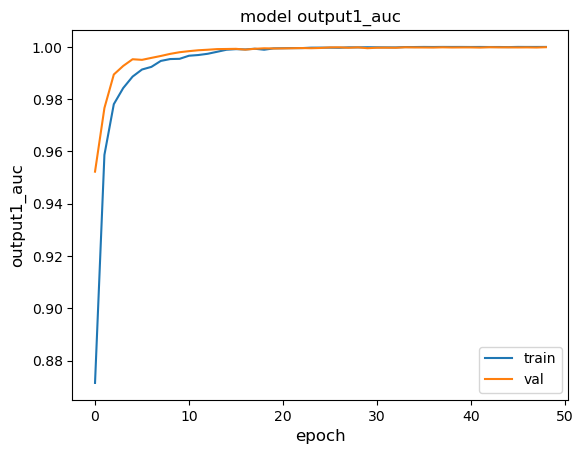

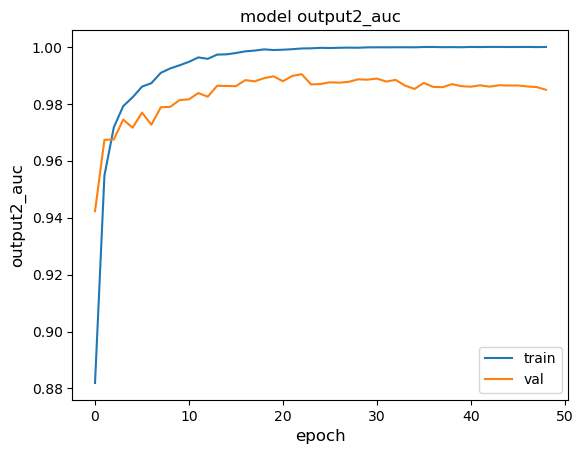

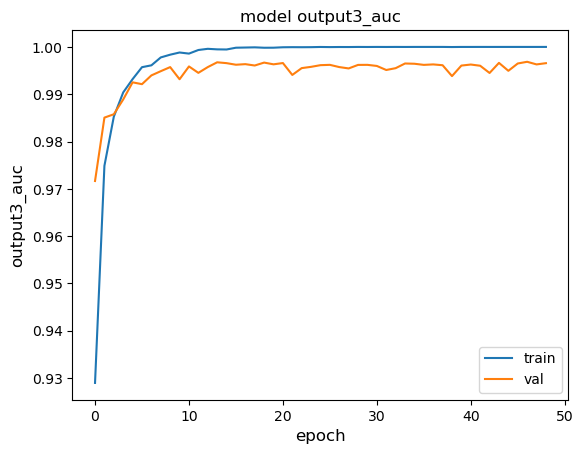

In [42]:
metrics = ["output1_auc","output2_auc", "output3_auc"]
for metric in metrics:
    plt.figure()
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric])
    plt.title("model " + metric)
    plt.ylabel(metric, fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "val"], loc="best")
    plt.show()
    plt.close()